In [1]:
import lightkurve as lk
import numpy as np

def download_sector(tic_id, author="SPOC"):
    search = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS", author=author)
    tbl = search.table
    data = {}
    sectors = np.unique(tbl["sequence_number"])
    for sec in sectors:
        mask = tbl["sequence_number"] == sec
        sub = tbl[mask]
        best_idx = np.argmin(sub["exptime"])
        row = search[mask][best_idx]

        exptime = sub["exptime"][best_idx]
        print(f"Downloading TIC {tic_id} Sector {sec} (exptime={exptime}s) ...")

        lc = (row.download(flux_column="pdcsap_flux")
                .remove_nans()
                .normalize())

        key = (int(sec), float(exptime))
        data[key] = lc

    return data

sector_data = download_sector(29857954)



ModuleNotFoundError: No module named 'lightkurve'

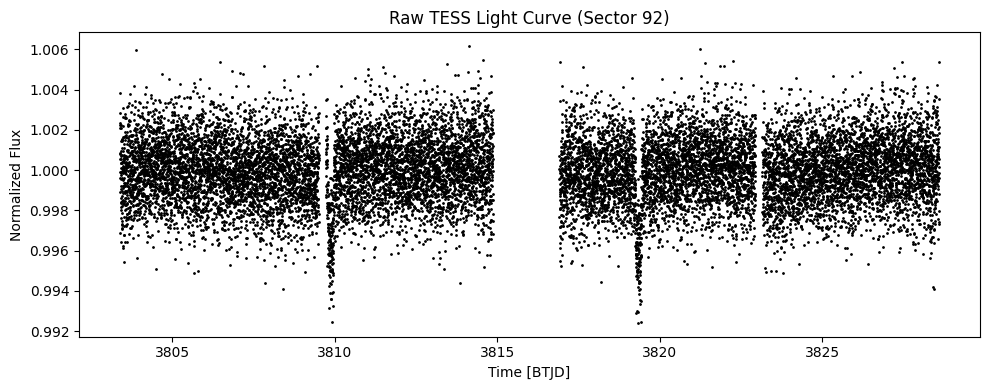

sigma = 0.0016291119391098619 prominence min = 0.0048873358173295856
找到的候选谷值个数: 42
候选时间: [3803.50866037 3803.93648095 3804.48931425 3805.09770852 3805.65331938
 3806.20754082 3806.77981917 3807.26319958 3807.86603563 3808.42025545
 3809.09531968 3809.91484133 3810.35238222 3810.85381767 3811.29552511
 3811.73167624 3812.37479039 3812.82899814 3813.35404536 3813.85409006
 3814.57915457 3817.07104834 3817.60998851 3818.20865659 3818.71564901
 3819.34209668 3819.94354142 3820.42414118 3820.84779095 3821.62147191
 3822.35070354 3823.28134079 3823.79805222 3824.28559408 3824.84397489
 3825.26206567 3825.74682839 3826.39966012 3826.88581098 3827.36501649
 3827.8720017  3828.43176865]
Transit candidates: 3809.9148413333896 3819.342096677204


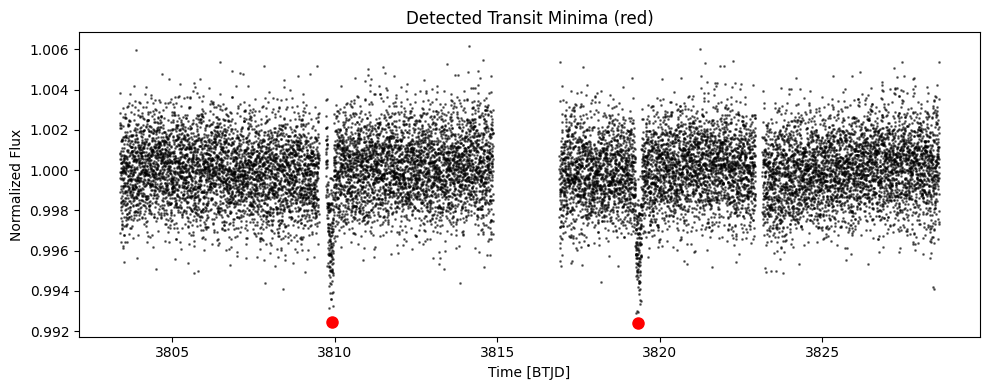

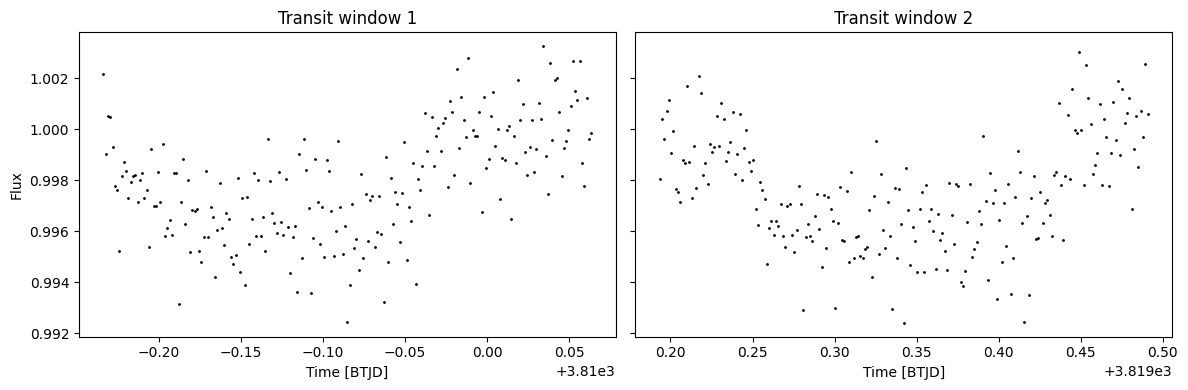

sample: 100%|██████████| 4000/4000 [00:07<00:00, 566.99it/s, 5 steps of size 7.61e-02. acc. prob=0.85]  

Transit 1 center time: 3810.111106 ± 0.014696
Transit 2 center time: 3819.538200 ± 0.016612
Difference (approx period): 9.427094 days


In [6]:

import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

from scipy.signal import find_peaks

jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")


lc = sector_data[(92,120)]

time_np = lc.time.value     
flux_np = lc.flux.value

plt.figure(figsize=(10,4))
plt.plot(time_np, flux_np, ".k", ms=2)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Raw TESS Light Curve (Sector 92)")
plt.tight_layout()
plt.show()

inv_flux = 1.0 - flux_np
sigma = float(np.std(flux_np)) 
prom_min = 3.0 * sigma

print("sigma =", sigma, "prominence min =", prom_min)

peaks, props = find_peaks(
    inv_flux,
    distance=300,
    prominence=prom_min )

if len(peaks) < 2:
    prom_min = 3.0 * sigma
    print(prom_min)
    peaks, props = find_peaks(
        inv_flux,
        distance=300,
        prominence=prom_min
    )
    print(len(peaks))
    print(time_np[peaks])

prom = props["prominences"]
order = np.argsort(prom)[::-1]
main_peaks = peaks[order[:2]]
main_peaks = np.sort(main_peaks)

idx1, idx2 = main_peaks
t0_guess1 = time_np[idx1]
t0_guess2 = time_np[idx2]

print("Transit candidates:", t0_guess1, t0_guess2)

plt.figure(figsize=(10,4))
plt.plot(time_np, flux_np, ".k", ms=2, alpha=0.5)
plt.plot(time_np[main_peaks], flux_np[main_peaks], "or", ms=8)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Detected Transit Minima (red)")
plt.tight_layout()
plt.show()


def cut_transit(time_array, flux_array, t_center, window=0.15):
    mask = np.abs(time_array - t_center) < window
    t_cut = time_array[mask]
    f_cut = flux_array[mask]
    sigma_loc = float(np.std(f_cut))
    e_cut = np.ones_like(f_cut) * sigma_loc
    return t_cut, f_cut, e_cut

t1, f1, e1 = cut_transit(time_np, flux_np, t0_guess1, window=0.15)
t2, f2, e2 = cut_transit(time_np, flux_np, t0_guess2, window=0.15)

fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)
axes[0].plot(t1, f1, ".k", ms=2)
axes[0].set_title("Transit window 1")
axes[1].plot(t2, f2, ".k", ms=2)
axes[1].set_title("Transit window 2")
for ax in axes:
    ax.set_xlabel("Time [BTJD]")
axes[0].set_ylabel("Flux")
plt.tight_layout()
plt.show()


def transit_model_local(t, yerr, y=None):
    t0 = numpyro.sample("t0", dist.Normal(t.mean(), 0.05))

    logD = numpyro.sample("logD", dist.Uniform(jnp.log(0.05), jnp.log(0.3)))
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    r = 0.08
    b = 0.5
    u = jnp.array([0.1, 0.06])

    orbit = TransitOrbit(
        period=10.0,
        duration=duration,
        time_transit=t0,
        impact_param=b,
        radius_ratio=r,
    )

    model = limb_dark_light_curve(orbit, u)(t)
    numpyro.sample("obs", dist.Normal(model, yerr), obs=y)


def fit_t0(time_array, flux_array, err_array, seed=0):
    t = jnp.array(time_array)
    f = jnp.array(flux_array)
    e = jnp.array(err_array)

    kernel = NUTS(transit_model_local)
    mcmc = MCMC(kernel, num_warmup=3000, num_samples=1000, num_chains=1)
    rng_key = jax.random.PRNGKey(seed)
    mcmc.run(rng_key, t, e, y=f)
    samples = mcmc.get_samples()

    t0_samples = np.array(samples["t0"])
    t0_mean = float(t0_samples.mean())
    t0_std  = float(t0_samples.std())
    return t0_mean, t0_std, samples
t0_1, t0_1_std, samples1 = fit_t0(t1, f1, e1, seed=1)
t0_2, t0_2_std, samples2 = fit_t0(t2, f2, e2, seed=2)

print(f"Transit 1 center time: {t0_1:.6f} ± {t0_1_std:.6f}")
print(f"Transit 2 center time: {t0_2:.6f} ± {t0_2_std:.6f}")
print(f"Difference (approx period): {t0_2 - t0_1:.6f} days")


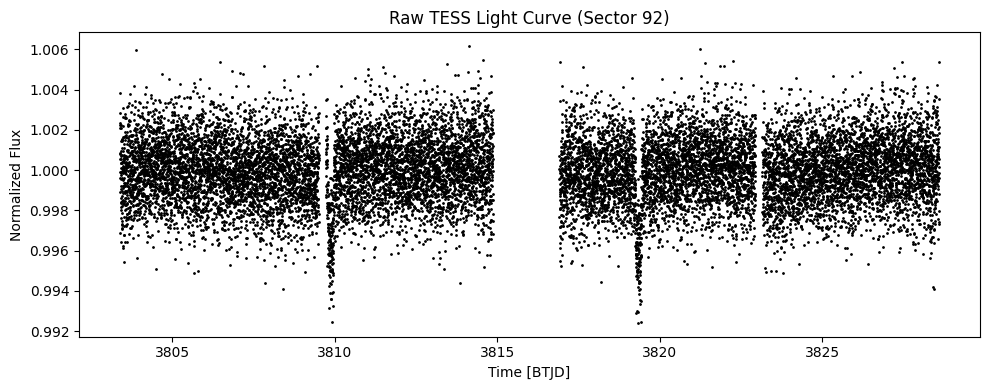

t0_guess = 3819.342096677204


sample: 100%|██████████| 2000/2000 [1:01:09<00:00,  1.83s/it, 1023 steps of size 1.05e-04. acc. prob=0.84]


===== Global transit fit (Sector 92) =====
t0       = 1.738497 ± 0.037158
Period   = 4.265488 ± 0.000041 days
Duration = 0.169169 ± 0.000107 days
r (Rp/R*)= 0.0455 ± 0.0010
b        = 0.1508 ± 0.0002
u1       = 0.8282 ± 0.0004
u2       = 0.8304 ± 0.0001
sigma_jit= 0.000351 ± 0.000048
model_flux_map min, max: 0.996480237286211 1.000428837523113


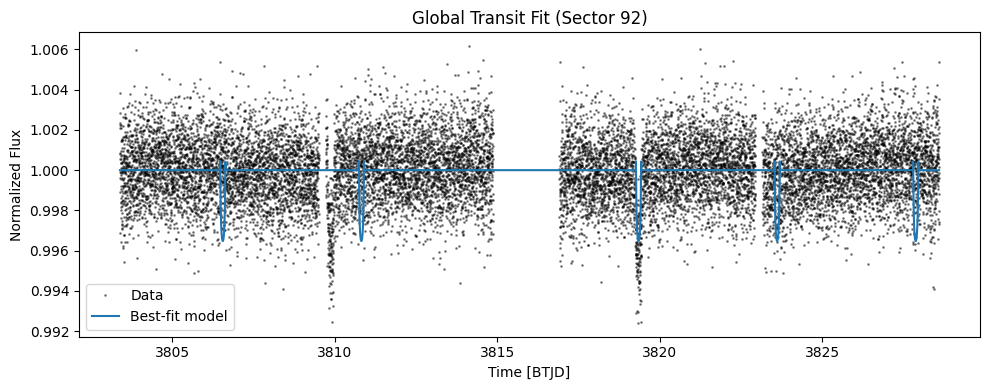

In [28]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")

# 读取 Sector 92 光变
lc = sector_data[(92, 120)]

time_np = lc.time.value
flux_np = lc.flux.value

# 去掉 NaN
mask = np.isfinite(time_np) & np.isfinite(flux_np)
time_np = time_np[mask]
flux_np = flux_np[mask]

plt.figure(figsize=(10, 4))
plt.plot(time_np, flux_np, ".k", ms=2)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Raw TESS Light Curve (Sector 92)")
plt.tight_layout()
plt.show()

# 简单误差估计
sigma0 = float(np.std(flux_np))
err_np = np.ones_like(flux_np) * sigma0

# 用最深点当 t0 初始猜测
t0_guess = float(time_np[np.argmin(flux_np)])
print("t0_guess =", t0_guess)

def transit_model_global(t, yerr, t0_guess, y=None):
    """
    Global transit model: 用整个 sector 的光变来拟合
    period, t0, duration, r, b, limb darkening, jitter.
    """

    # t0
    t0 = numpyro.sample("t0", dist.Normal(t0_guess, 1.0))

    # period: log-uniform [1, 20] 天
    logP = numpyro.sample("logP", dist.Uniform(jnp.log(1.0), jnp.log(20.0)))
    P = numpyro.deterministic("period", jnp.exp(logP))

    # duration: log-uniform [0.05, 0.3] 天
    logD = numpyro.sample("logD", dist.Uniform(jnp.log(0.05), jnp.log(0.3)))
    D = numpyro.deterministic("duration", jnp.exp(logD))

    # 行星和几何参数
    r = numpyro.sample("r", dist.Uniform(0.0001, 0.3))
    b = numpyro.sample("b", dist.Uniform(0.0, 1.0))

    # limb darkening
    u1 = numpyro.sample("u1", dist.Uniform(0.0, 1.0))
    u2 = numpyro.sample("u2", dist.Uniform(0.0, 1.0))
    u = jnp.array([u1, u2])

    # jitter
    sigma_jit = numpyro.sample("sigma_jit", dist.HalfNormal(0.0002))

    # 轨道
    orbit = TransitOrbit(
        period=P,
        duration=D,
        time_transit=t0,
        impact_param=b,
        radius_ratio=r,
    )

    # ★ 关键修改：先算 ΔF，再做 1 + ΔF 变成归一化通量
    delta_flux = limb_dark_light_curve(orbit, u)(t)   # ΔF, out-of-transit≈0, transit<0
    model_flux = 1.0 + delta_flux                     # baseline≈1，有凌星时往下掉

    # 似然
    sigma_tot = jnp.sqrt(yerr**2 + sigma_jit**2)
    numpyro.sample("obs", dist.Normal(model_flux, sigma_tot), obs=y)



# 运行 MCMC
t = jnp.array(time_np)
f = jnp.array(flux_np)
e = jnp.array(err_np)

kernel = NUTS(transit_model_global)
mcmc = MCMC(kernel, num_warmup=1500, num_samples=500, num_chains=1)

rng_key = jax.random.PRNGKey(42)
mcmc.run(rng_key, t, e, t0_guess, y=f)
samples = mcmc.get_samples()


def summarize_param(name):
    arr = np.array(samples[name])
    return arr.mean(), arr.std()


t0_mean, t0_std = summarize_param("t0")
P_mean, P_std = summarize_param("period")
D_mean, D_std = summarize_param("duration")
r_mean, r_std = summarize_param("r")
b_mean, b_std = summarize_param("b")
u1_mean, u1_std = summarize_param("u1")
u2_mean, u2_std = summarize_param("u2")
sj_mean, sj_std = summarize_param("sigma_jit")

print("===== Global transit fit (Sector 92) =====")
print(f"t0       = {t0_mean:.6f} ± {t0_std:.6f}")
print(f"Period   = {P_mean:.6f} ± {P_std:.6f} days")
print(f"Duration = {D_mean:.6f} ± {D_std:.6f} days")
print(f"r (Rp/R*)= {r_mean:.4f} ± {r_std:.4f}")
print(f"b        = {b_mean:.4f} ± {b_std:.4f}")
print(f"u1       = {u1_mean:.4f} ± {u1_std:.4f}")
print(f"u2       = {u2_mean:.4f} ± {u2_std:.4f}")
print(f"sigma_jit= {sj_mean:.6f} ± {sj_std:.6f}")

# 用后验中位数画 best-fit model
theta_med = {k: np.median(np.array(v)) for k, v in samples.items()}

orbit_map = TransitOrbit(
    period=theta_med["period"],
    duration=theta_med["duration"],
    time_transit=theta_med["t0"],
    impact_param=theta_med["b"],
    radius_ratio=theta_med["r"],
)
u_map = jnp.array([theta_med["u1"], theta_med["u2"]])

delta_flux_map = limb_dark_light_curve(orbit_map, u_map)(t)
model_flux_map = 1.0 + np.array(delta_flux_map)


print("model_flux_map min, max:", model_flux_map.min(), model_flux_map.max())

plt.figure(figsize=(10, 4))
plt.plot(time_np, flux_np, ".k", ms=2, alpha=0.4, label="Data")
plt.plot(time_np, model_flux_map, "-", lw=1.5, label="Best-fit model")
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Global Transit Fit (Sector 92)")
plt.legend()
plt.tight_layout()
plt.show()


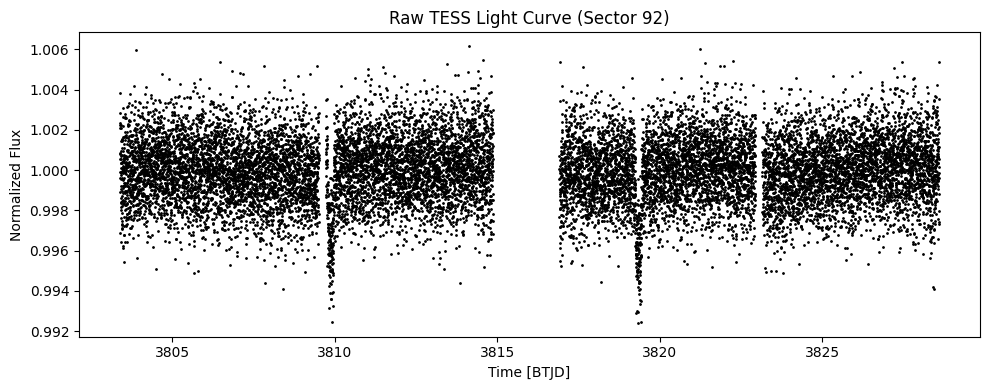

t0_guess = 3819.342096677204
rough depth_est, r_guess = 0.0075865983963012695 0.08710108148755255


sample: 100%|██████████| 1500/1500 [01:54<00:00, 13.15it/s, 1 steps of size 6.04e-04. acc. prob=0.21]  


===== Global transit fit (Sector 92) =====
t0       = 1.596752 ± 0.000024
Period   = 10.577874 ± 0.000088 days
Duration = 0.168485 ± 0.000002 days
r (Rp/R*)= 0.1929 ± 0.0000
b        = 0.1526 ± 0.0000
u1       = 0.8254 ± 0.0000
u2       = 0.8309 ± 0.0000
sigma_jit= 0.004671 ± 0.000948
model_flux_map min, max: 0.9376783191668758 1.0011296190491181


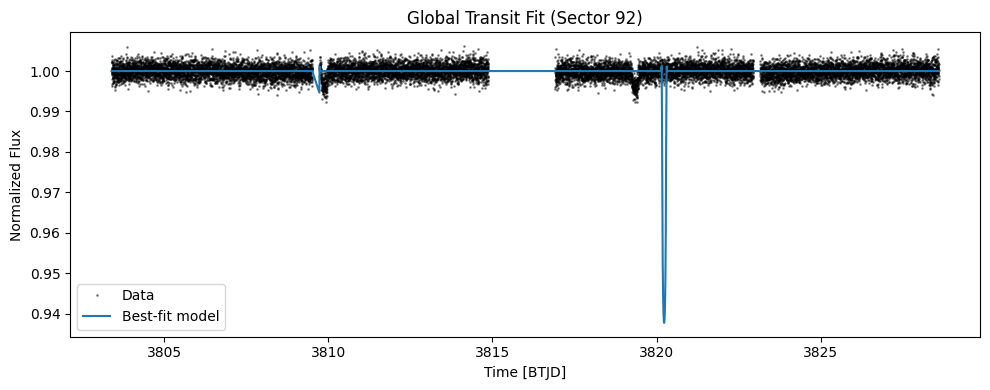

In [5]:
#全局拟合
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")

lc = sector_data[(92, 120)]

time_np = lc.time.value
flux_np = lc.flux.value

mask = np.isfinite(time_np) & np.isfinite(flux_np)
time_np = time_np[mask]
flux_np = flux_np[mask]

plt.figure(figsize=(10, 4))
plt.plot(time_np, flux_np, ".k", ms=2)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Raw TESS Light Curve (Sector 92)")
plt.tight_layout()
plt.show()

sigma0 = float(np.std(flux_np))
err_np = np.ones_like(flux_np) * sigma0

t0_guess = float(time_np[np.argmin(flux_np)])
print("t0_guess =", t0_guess)

P_GUESS = 9.47725

depth_est = float(1.0 - flux_np.min())
depth_est = max(depth_est, 1e-4)
r_guess = np.sqrt(depth_est)         
print("rough depth_est, r_guess =", depth_est, r_guess)


def transit_model_global(t, yerr, t0_guess, y=None):

    t0 = numpyro.sample("t0", dist.Normal(t0_guess, 0.5))

    logP = numpyro.sample("logP", dist.Normal(jnp.log(P_GUESS), 0.001))
    P = numpyro.deterministic("period", jnp.exp(logP))

    logD = numpyro.sample("logD", dist.Uniform(jnp.log(0.05), jnp.log(0.3)))
    D = numpyro.deterministic("duration", jnp.exp(logD))

    log_r = numpyro.sample("log_r", dist.Normal(jnp.log(r_guess), 0.5))
    r = numpyro.deterministic("r", jnp.exp(log_r))

    b = numpyro.sample("b", dist.Uniform(0.0, 1.0))

    u1 = numpyro.sample("u1", dist.Uniform(0.0, 1.0))
    u2 = numpyro.sample("u2", dist.Uniform(0.0, 1.0))
    u = jnp.array([u1, u2])

    sigma_jit = numpyro.sample("sigma_jit", dist.HalfNormal(0.0002))

    orbit = TransitOrbit(
        period=P,
        duration=D,
        time_transit=t0,
        impact_param=b,
        radius_ratio=r,
    )

    delta_flux = limb_dark_light_curve(orbit, u)(t)
    model_flux = 1.0 + delta_flux

    sigma_tot = jnp.sqrt(yerr**2 + sigma_jit**2)
    numpyro.sample("obs", dist.Normal(model_flux, sigma_tot), obs=y)


t = jnp.array(time_np)
f = jnp.array(flux_np)
e = jnp.array(err_np)

kernel = NUTS(transit_model_global)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=500, num_chains=1)
#adding optimization
rng_key = jax.random.PRNGKey(42)
mcmc.run(rng_key, t, e, t0_guess, y=f)
samples = mcmc.get_samples()


def summarize_param(name):
    arr = np.array(samples[name])
    return arr.mean(), arr.std()


t0_mean, t0_std = summarize_param("t0")
P_mean, P_std = summarize_param("period")
D_mean, D_std = summarize_param("duration")
r_mean, r_std = summarize_param("r")
b_mean, b_std = summarize_param("b")
u1_mean, u1_std = summarize_param("u1")
u2_mean, u2_std = summarize_param("u2")
sj_mean, sj_std = summarize_param("sigma_jit")

print("===== Global transit fit (Sector 92) =====")
print(f"t0       = {t0_mean:.6f} ± {t0_std:.6f}")
print(f"Period   = {P_mean:.6f} ± {P_std:.6f} days")
print(f"Duration = {D_mean:.6f} ± {D_std:.6f} days")
print(f"r (Rp/R*)= {r_mean:.4f} ± {r_std:.4f}")
print(f"b        = {b_mean:.4f} ± {b_std:.4f}")
print(f"u1       = {u1_mean:.4f} ± {u1_std:.4f}")
print(f"u2       = {u2_mean:.4f} ± {u2_std:.4f}")
print(f"sigma_jit= {sj_mean:.6f} ± {sj_std:.6f}")

theta_med = {k: np.median(np.array(v)) for k, v in samples.items()}

orbit_map = TransitOrbit(
    period=theta_med["period"],
    duration=theta_med["duration"],
    time_transit=theta_med["t0"],
    impact_param=theta_med["b"],
    radius_ratio=theta_med["r"],
)
u_map = jnp.array([theta_med["u1"], theta_med["u2"]])

delta_flux_map = limb_dark_light_curve(orbit_map, u_map)(t)
model_flux_map = 1.0 + np.array(delta_flux_map)

print("model_flux_map min, max:", model_flux_map.min(), model_flux_map.max())

plt.figure(figsize=(10, 4))
plt.plot(time_np, flux_np, ".k", ms=2, alpha=0.4, label="Data")
plt.plot(time_np, model_flux_map, "-", lw=1.5, label="Best-fit model")
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Global Transit Fit (Sector 92)")
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
lc_all = sector_data[(92,120)]
lc_all = lc_all.append(sector_data[(95,120)])


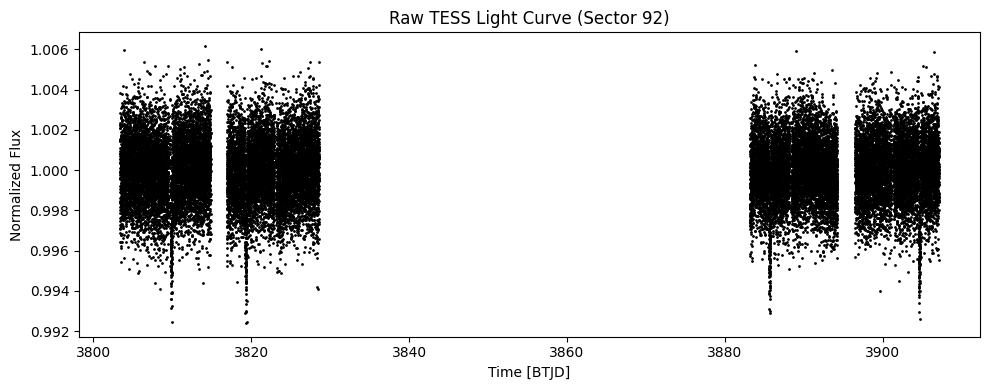

t0_guess = 3819.342096677204
rough depth_est, r_guess = 0.0075865983963012695 0.08710108148755255


sample: 100%|██████████| 1500/1500 [1:46:03<00:00,  4.24s/it, 1023 steps of size 3.58e-04. acc. prob=0.87]


===== Global transit fit (Sector 92) =====
t0       = 3818.330795 ± 0.064920
Period   = 9.477250 ± 0.000000 days
Duration = 0.068233 ± 0.002051 days
r (Rp/R*)= 0.0158 ± 0.0020
b        = 0.1581 ± 0.0087
u1       = 0.1423 ± 0.0076
u2       = 0.8874 ± 0.0573
sigma_jit= 0.000100 ± 0.000037
model_flux_map min, max: 0.9996813907448565 1.0


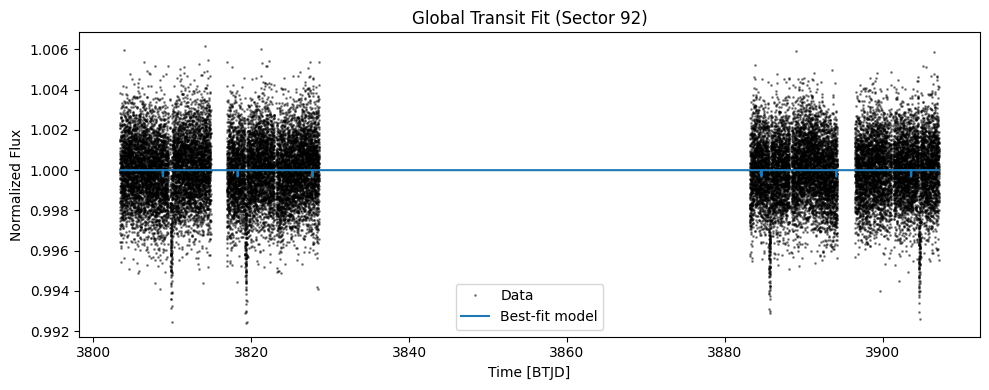

In [11]:
#全局拟合
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")

lc = lc_all

time_np = lc.time.value
flux_np = lc.flux.value

mask = np.isfinite(time_np) & np.isfinite(flux_np)
time_np = time_np[mask]
flux_np = flux_np[mask]

plt.figure(figsize=(10, 4))
plt.plot(time_np, flux_np, ".k", ms=2)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Raw TESS Light Curve (Sector 92)")
plt.tight_layout()
plt.show()

sigma0 = float(np.std(flux_np))
err_np = np.ones_like(flux_np) * sigma0

t0_guess = float(time_np[np.argmin(flux_np)])
print("t0_guess =", t0_guess)

P_GUESS = 9.47725

depth_est = float(1.0 - flux_np.min())
depth_est = max(depth_est, 1e-4)
r_guess = np.sqrt(depth_est)         
print("rough depth_est, r_guess =", depth_est, r_guess)


def transit_model_global(t, yerr, t0_guess, y=None):

    t0 = numpyro.sample("t0", dist.Normal(t0_guess, 0.5))

    #logP = numpyro.sample("logP", dist.Normal(jnp.log(P_GUESS), 0.001))
    #P = numpyro.deterministic("period", jnp.exp(logP))
    P = numpyro.deterministic("period", P_GUESS)

    logD = numpyro.sample("logD", dist.Uniform(jnp.log(0.05), jnp.log(0.3)))
    D = numpyro.deterministic("duration", jnp.exp(logD))

    log_r = numpyro.sample("log_r", dist.Normal(jnp.log(r_guess), 0.5))
    r = numpyro.deterministic("r", jnp.exp(log_r))

    b = numpyro.sample("b", dist.Uniform(0.0, 1.0))

    u1 = numpyro.sample("u1", dist.Uniform(0.0, 1.0))
    u2 = numpyro.sample("u2", dist.Uniform(0.0, 1.0))
    u = jnp.array([u1, u2])

    sigma_jit = numpyro.sample("sigma_jit", dist.HalfNormal(0.0002))

    orbit = TransitOrbit(
        period=P,
        duration=D,
        time_transit=t0,
        impact_param=b,
        radius_ratio=r,
    )

    delta_flux = limb_dark_light_curve(orbit, u)(t)
    model_flux = 1.0 + delta_flux

    sigma_tot = jnp.sqrt(yerr**2 + sigma_jit**2)
    numpyro.sample("obs", dist.Normal(model_flux, sigma_tot), obs=y)


t = jnp.array(time_np)
f = jnp.array(flux_np)
e = jnp.array(err_np)

kernel = NUTS(transit_model_global)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=500, num_chains=1)
#adding optimization
rng_key = jax.random.PRNGKey(42)
mcmc.run(rng_key, t, e, t0_guess, y=f)
samples = mcmc.get_samples()


def summarize_param(name):
    arr = np.array(samples[name])
    return arr.mean(), arr.std()


t0_mean, t0_std = summarize_param("t0")
P_mean, P_std = summarize_param("period")
D_mean, D_std = summarize_param("duration")
r_mean, r_std = summarize_param("r")
b_mean, b_std = summarize_param("b")
u1_mean, u1_std = summarize_param("u1")
u2_mean, u2_std = summarize_param("u2")
sj_mean, sj_std = summarize_param("sigma_jit")

print("===== Global transit fit (Sector 92) =====")
print(f"t0       = {t0_mean:.6f} ± {t0_std:.6f}")
print(f"Period   = {P_mean:.6f} ± {P_std:.6f} days")
print(f"Duration = {D_mean:.6f} ± {D_std:.6f} days")
print(f"r (Rp/R*)= {r_mean:.4f} ± {r_std:.4f}")
print(f"b        = {b_mean:.4f} ± {b_std:.4f}")
print(f"u1       = {u1_mean:.4f} ± {u1_std:.4f}")
print(f"u2       = {u2_mean:.4f} ± {u2_std:.4f}")
print(f"sigma_jit= {sj_mean:.6f} ± {sj_std:.6f}")

theta_med = {k: np.median(np.array(v)) for k, v in samples.items()}

orbit_map = TransitOrbit(
    period=theta_med["period"],
    duration=theta_med["duration"],
    time_transit=theta_med["t0"],
    impact_param=theta_med["b"],
    radius_ratio=theta_med["r"],
)
u_map = jnp.array([theta_med["u1"], theta_med["u2"]])

delta_flux_map = limb_dark_light_curve(orbit_map, u_map)(t)
model_flux_map = 1.0 + np.array(delta_flux_map)

print("model_flux_map min, max:", model_flux_map.min(), model_flux_map.max())

plt.figure(figsize=(10, 4))
plt.plot(time_np, flux_np, ".k", ms=2, alpha=0.4, label="Data")
plt.plot(time_np, model_flux_map, "-", lw=1.5, label="Best-fit model")
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Global Transit Fit (Sector 92)")
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")

# === 配置 ===
# 选择要用的 sector（来自前面 download_sector 得到的字典键）
sectors_to_use = lc_all # 示例，按需修改
P_FIXED = P_GUESS                           # 用你固定拟合成功的周期
WINDOW_LEN = 401                         # flatten 窗口，偶尔可改 301

# === 数据准备：每个 sector 独立去 NaN、归一化、flatten、估计误差 ===
t_list, f_list, e_list, sid_list = [], [], [], []
for i, key in enumerate(sectors_to_use):
    lc = (sector_data[key]
          .remove_nans()
          .normalize()
          .flatten(window_length=WINDOW_LEN, polyorder=2))
    time = lc.time.value
    flux = lc.flux.value
    mask = np.isfinite(time) & np.isfinite(flux)
    time = time[mask]
    flux = flux[mask]
    sigma = float(np.std(flux))
    t_list.append(time)
    f_list.append(flux)
    e_list.append(np.ones_like(flux) * sigma)
    sid_list.append(np.full_like(flux, i))

t_all = jnp.concatenate([jnp.array(x) for x in t_list])
f_all = jnp.concatenate([jnp.array(x) for x in f_list])
e_all = jnp.concatenate([jnp.array(x) for x in e_list])
sid_all = jnp.concatenate([jnp.array(x) for x in sid_list])

t_ref = float(np.mean(np.concatenate(t_list)))
n_sec = len(sectors_to_use)

# === 模型：共享几何 & P，per-sector offset/线性趋势/jitter ===
def transit_model_multi(t, yerr, sid, P_fixed, t_ref, y=None):
    t0 = numpyro.sample("t0", dist.Normal(t_ref, 0.3))
    logD = numpyro.sample("logD", dist.Uniform(jnp.log(0.05), jnp.log(0.3)))
    D = numpyro.deterministic("duration", jnp.exp(logD))
    r = numpyro.sample("r", dist.Uniform(0.02, 0.2))
    b = numpyro.sample("b", dist.Uniform(0.0, 0.9))
    u1 = numpyro.sample("u1", dist.Uniform(0.0, 1.0))
    u2 = numpyro.sample("u2", dist.Uniform(0.0, 1.0))
    u = jnp.array([u1, u2])

    offset = numpyro.sample("offset", dist.Normal(jnp.zeros(n_sec), 0.002))
    slope  = numpyro.sample("slope", dist.Normal(jnp.zeros(n_sec), 0.001))
    sigma_jit = numpyro.sample("sigma_jit", dist.HalfNormal(jnp.ones(n_sec) * 0.002))

    orbit = TransitOrbit(period=P_fixed, duration=D, time_transit=t0,
                         impact_param=b, radius_ratio=r)
    delta = limb_dark_light_curve(orbit, u)(t)
    model = 1.0 + delta + offset[sid] + slope[sid] * (t - t_ref)
    sigma_tot = jnp.sqrt(yerr**2 + sigma_jit[sid]**2)
    numpyro.sample("obs", dist.Normal(model, sigma_tot), obs=y)

# === 采样 ===
kernel = NUTS(transit_model_multi)
mcmc = MCMC(kernel, num_warmup=1500, num_samples=800, num_chains=2, progress_bar=True)
rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key, t_all, e_all, sid_all, P_FIXED, t_ref, y=f_all)
samples = mcmc.get_samples()

# === 打印后验均值 ± std ===
def summarize(name):
    arr = np.array(samples[name])
    return arr.mean(), arr.std()

t0_mean, t0_std = summarize("t0")
D_mean, D_std = summarize("duration")
r_mean, r_std = summarize("r")
b_mean, b_std = summarize("b")
u1_mean, u1_std = summarize("u1")
u2_mean, u2_std = summarize("u2")
off_mean = np.array(samples["offset"]).mean(axis=0)
slp_mean = np.array(samples["slope"]).mean(axis=0)
jit_mean = np.array(samples["sigma_jit"]).mean(axis=0)

print("=== Multi-sector fit ===")
print(f"P (fixed)   = {P_FIXED:.6f}")
print(f"t0          = {t0_mean:.6f} ± {t0_std:.6f}")
print(f"Duration    = {D_mean:.6f} ± {D_std:.6f}")
print(f"r (Rp/R*)   = {r_mean:.4f} ± {r_std:.4f}")
print(f"b           = {b_mean:.4f} ± {b_std:.4f}")
print(f"u1          = {u1_mean:.4f} ± {u1_std:.4f}")
print(f"u2          = {u2_mean:.4f} ± {u2_std:.4f}")
for i, key in enumerate(sectors_to_use):
    print(f"Sector {key}: offset={off_mean[i]:+.5f}, slope={slp_mean[i]:+.5f}, jit={jit_mean[i]:.5f}")

# === 画 best-fit ===
theta_med = {k: np.median(np.array(v), axis=0) for k, v in samples.items()}
orbit_map = TransitOrbit(period=P_FIXED,
                         duration=theta_med["duration"],
                         time_transit=theta_med["t0"],
                         impact_param=theta_med["b"],
                         radius_ratio=theta_med["r"])
u_map = jnp.array([theta_med["u1"], theta_med["u2"]])

delta_map = limb_dark_light_curve(orbit_map, u_map)(t_all)
model_map = 1.0 + np.array(delta_map) \
            + theta_med["offset"][sid_all] \
            + theta_med["slope"][sid_all] * (t_all - t_ref)

plt.figure(figsize=(10,4))
plt.plot(np.array(t_all), np.array(f_all), ".k", ms=2, alpha=0.4, label="Data")
plt.plot(np.array(t_all), model_map, "-", lw=1.2, label="MAP model")
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Global Transit Fit, Multi-Sector (P fixed)")
plt.legend()
plt.tight_layout()
plt.show()


TypeError: unhashable type: 'Row'

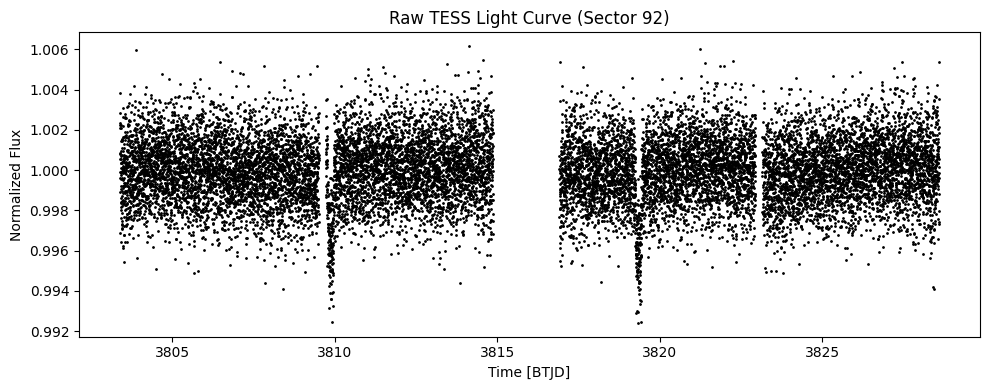

t0_guess = 3819.342096677204


sample: 100%|██████████| 2000/2000 [1:01:09<00:00,  1.83s/it, 1023 steps of size 1.05e-04. acc. prob=0.84]


===== Global transit fit (Sector 92) =====
t0       = 1.738497 ± 0.037158
Period   = 4.265488 ± 0.000041 days
Duration = 0.169169 ± 0.000107 days
r (Rp/R*)= 0.0455 ± 0.0010
b        = 0.1508 ± 0.0002
u1       = 0.8282 ± 0.0004
u2       = 0.8304 ± 0.0001
sigma_jit= 0.000351 ± 0.000048
model_flux_map min, max: 0.996480237286211 1.000428837523113


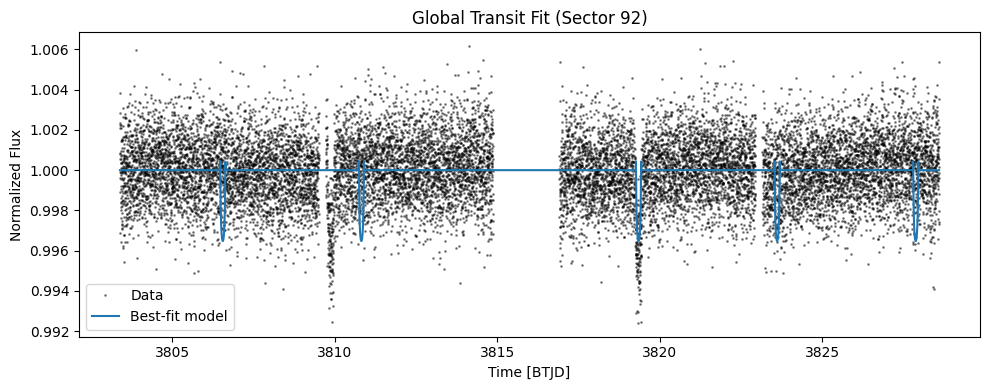

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")

# 读取 Sector 92 光变
lc = sector_data[(92, 120)]

time_np = lc.time.value
flux_np = lc.flux.value

# 去掉 NaN
mask = np.isfinite(time_np) & np.isfinite(flux_np)
time_np = time_np[mask]
flux_np = flux_np[mask]

plt.figure(figsize=(10, 4))
plt.plot(time_np, flux_np, ".k", ms=2)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Raw TESS Light Curve (Sector 92)")
plt.tight_layout()
plt.show()

# 简单误差估计
sigma0 = float(np.std(flux_np))
err_np = np.ones_like(flux_np) * sigma0

# 用最深点当 t0 初始猜测
t0_guess = float(time_np[np.argmin(flux_np)])
print("t0_guess =", t0_guess)

def transit_model_global(t, yerr, t0_guess, y=None):
    """
    Global transit model: 用整个 sector 的光变来拟合
    period, t0, duration, r, b, limb darkening, jitter.
    """

    # t0
    t0 = numpyro.sample("t0", dist.Normal(t0_guess, 1.0))

    # period: log-uniform [1, 20] 天
    logP = numpyro.sample("logP", dist.Uniform(jnp.log(1.0), jnp.log(20.0)))
    P = numpyro.deterministic("period", jnp.exp(logP))

    # duration: log-uniform [0.05, 0.3] 天
    logD = numpyro.sample("logD", dist.Uniform(jnp.log(0.05), jnp.log(0.3)))
    D = numpyro.deterministic("duration", jnp.exp(logD))

    # 行星和几何参数
    r = numpyro.sample("r", dist.Uniform(0.0001, 0.3))
    b = numpyro.sample("b", dist.Uniform(0.0, 1.0))

    # limb darkening
    u1 = numpyro.sample("u1", dist.Uniform(0.0, 1.0))
    u2 = numpyro.sample("u2", dist.Uniform(0.0, 1.0))
    u = jnp.array([u1, u2])

    # jitter
    sigma_jit = numpyro.sample("sigma_jit", dist.HalfNormal(0.0002))

    # 轨道
    orbit = TransitOrbit(
        period=P,
        duration=D,
        time_transit=t0,
        impact_param=b,
        radius_ratio=r,
    )

    # ★ 关键修改：先算 ΔF，再做 1 + ΔF 变成归一化通量
    delta_flux = limb_dark_light_curve(orbit, u)(t)   # ΔF, out-of-transit≈0, transit<0
    model_flux = 1.0 + delta_flux                     # baseline≈1，有凌星时往下掉

    # 似然
    sigma_tot = jnp.sqrt(yerr**2 + sigma_jit**2)
    numpyro.sample("obs", dist.Normal(model_flux, sigma_tot), obs=y)



# 运行 MCMC
t = jnp.array(time_np)
f = jnp.array(flux_np)
e = jnp.array(err_np)

kernel = NUTS(transit_model_global)
mcmc = MCMC(kernel, num_warmup=1500, num_samples=500, num_chains=1)

rng_key = jax.random.PRNGKey(42)
mcmc.run(rng_key, t, e, t0_guess, y=f)
samples = mcmc.get_samples()


def summarize_param(name):
    arr = np.array(samples[name])
    return arr.mean(), arr.std()


t0_mean, t0_std = summarize_param("t0")
P_mean, P_std = summarize_param("period")
D_mean, D_std = summarize_param("duration")
r_mean, r_std = summarize_param("r")
b_mean, b_std = summarize_param("b")
u1_mean, u1_std = summarize_param("u1")
u2_mean, u2_std = summarize_param("u2")
sj_mean, sj_std = summarize_param("sigma_jit")

print("===== Global transit fit (Sector 92) =====")
print(f"t0       = {t0_mean:.6f} ± {t0_std:.6f}")
print(f"Period   = {P_mean:.6f} ± {P_std:.6f} days")
print(f"Duration = {D_mean:.6f} ± {D_std:.6f} days")
print(f"r (Rp/R*)= {r_mean:.4f} ± {r_std:.4f}")
print(f"b        = {b_mean:.4f} ± {b_std:.4f}")
print(f"u1       = {u1_mean:.4f} ± {u1_std:.4f}")
print(f"u2       = {u2_mean:.4f} ± {u2_std:.4f}")
print(f"sigma_jit= {sj_mean:.6f} ± {sj_std:.6f}")

# 用后验中位数画 best-fit model
theta_med = {k: np.median(np.array(v)) for k, v in samples.items()}

orbit_map = TransitOrbit(
    period=theta_med["period"],
    duration=theta_med["duration"],
    time_transit=theta_med["t0"],
    impact_param=theta_med["b"],
    radius_ratio=theta_med["r"],
)
u_map = jnp.array([theta_med["u1"], theta_med["u2"]])

delta_flux_map = limb_dark_light_curve(orbit_map, u_map)(t)
model_flux_map = 1.0 + np.array(delta_flux_map)


print("model_flux_map min, max:", model_flux_map.min(), model_flux_map.max())

plt.figure(figsize=(10, 4))
plt.plot(time_np, flux_np, ".k", ms=2, alpha=0.4, label="Data")
plt.plot(time_np, model_flux_map, "-", lw=1.5, label="Best-fit model")
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Global Transit Fit (Sector 92)")
plt.legend()
plt.tight_layout()
plt.show()


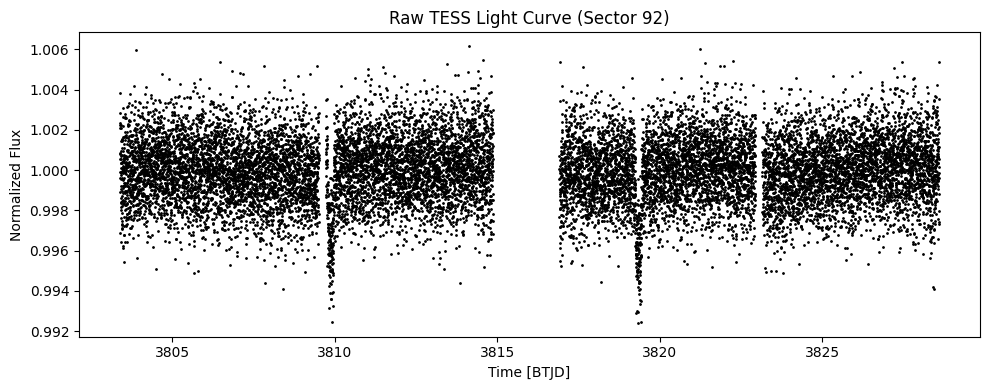

t0_guess = 3819.342096677204


sample: 100%|██████████| 2000/2000 [1:01:09<00:00,  1.83s/it, 1023 steps of size 1.05e-04. acc. prob=0.84]


===== Global transit fit (Sector 92) =====
t0       = 1.738497 ± 0.037158
Period   = 4.265488 ± 0.000041 days
Duration = 0.169169 ± 0.000107 days
r (Rp/R*)= 0.0455 ± 0.0010
b        = 0.1508 ± 0.0002
u1       = 0.8282 ± 0.0004
u2       = 0.8304 ± 0.0001
sigma_jit= 0.000351 ± 0.000048
model_flux_map min, max: 0.996480237286211 1.000428837523113


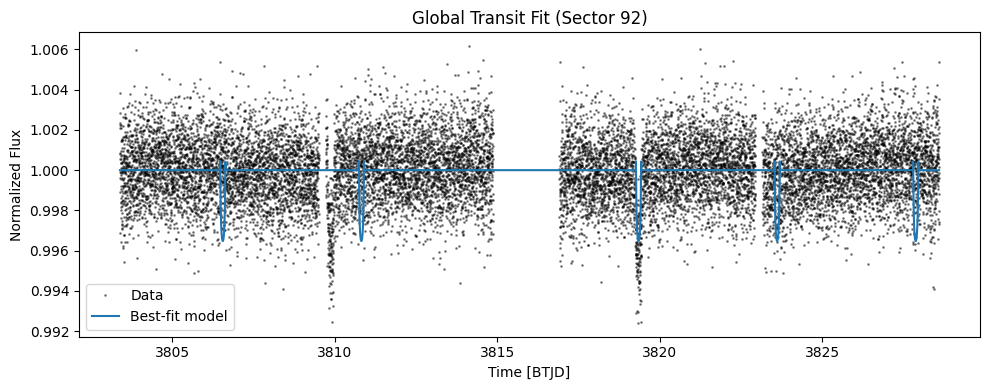

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")

# 读取 Sector 92 光变
lc = sector_data[(92, 120)]

time_np = lc.time.value
flux_np = lc.flux.value

# 去掉 NaN
mask = np.isfinite(time_np) & np.isfinite(flux_np)
time_np = time_np[mask]
flux_np = flux_np[mask]

plt.figure(figsize=(10, 4))
plt.plot(time_np, flux_np, ".k", ms=2)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Raw TESS Light Curve (Sector 92)")
plt.tight_layout()
plt.show()

# 简单误差估计
sigma0 = float(np.std(flux_np))
err_np = np.ones_like(flux_np) * sigma0

# 用最深点当 t0 初始猜测
t0_guess = float(time_np[np.argmin(flux_np)])
print("t0_guess =", t0_guess)

def transit_model_global(t, yerr, t0_guess, y=None):
    """
    Global transit model: 用整个 sector 的光变来拟合
    period, t0, duration, r, b, limb darkening, jitter.
    """

    # t0
    t0 = numpyro.sample("t0", dist.Normal(t0_guess, 1.0))

    # period: log-uniform [1, 20] 天
    logP = numpyro.sample("logP", dist.Uniform(jnp.log(1.0), jnp.log(20.0)))
    P = numpyro.deterministic("period", jnp.exp(logP))

    # duration: log-uniform [0.05, 0.3] 天
    logD = numpyro.sample("logD", dist.Uniform(jnp.log(0.05), jnp.log(0.3)))
    D = numpyro.deterministic("duration", jnp.exp(logD))

    # 行星和几何参数
    r = numpyro.sample("r", dist.Uniform(0.0001, 0.3))
    b = numpyro.sample("b", dist.Uniform(0.0, 1.0))

    # limb darkening
    u1 = numpyro.sample("u1", dist.Uniform(0.0, 1.0))
    u2 = numpyro.sample("u2", dist.Uniform(0.0, 1.0))
    u = jnp.array([u1, u2])

    # jitter
    sigma_jit = numpyro.sample("sigma_jit", dist.HalfNormal(0.0002))

    # 轨道
    orbit = TransitOrbit(
        period=P,
        duration=D,
        time_transit=t0,
        impact_param=b,
        radius_ratio=r,
    )

    # ★ 关键修改：先算 ΔF，再做 1 + ΔF 变成归一化通量
    delta_flux = limb_dark_light_curve(orbit, u)(t)   # ΔF, out-of-transit≈0, transit<0
    model_flux = 1.0 + delta_flux                     # baseline≈1，有凌星时往下掉

    # 似然
    sigma_tot = jnp.sqrt(yerr**2 + sigma_jit**2)
    numpyro.sample("obs", dist.Normal(model_flux, sigma_tot), obs=y)



# 运行 MCMC
t = jnp.array(time_np)
f = jnp.array(flux_np)
e = jnp.array(err_np)

kernel = NUTS(transit_model_global)
mcmc = MCMC(kernel, num_warmup=1500, num_samples=500, num_chains=1)

rng_key = jax.random.PRNGKey(42)
mcmc.run(rng_key, t, e, t0_guess, y=f)
samples = mcmc.get_samples()


def summarize_param(name):
    arr = np.array(samples[name])
    return arr.mean(), arr.std()


t0_mean, t0_std = summarize_param("t0")
P_mean, P_std = summarize_param("period")
D_mean, D_std = summarize_param("duration")
r_mean, r_std = summarize_param("r")
b_mean, b_std = summarize_param("b")
u1_mean, u1_std = summarize_param("u1")
u2_mean, u2_std = summarize_param("u2")
sj_mean, sj_std = summarize_param("sigma_jit")

print("===== Global transit fit (Sector 92) =====")
print(f"t0       = {t0_mean:.6f} ± {t0_std:.6f}")
print(f"Period   = {P_mean:.6f} ± {P_std:.6f} days")
print(f"Duration = {D_mean:.6f} ± {D_std:.6f} days")
print(f"r (Rp/R*)= {r_mean:.4f} ± {r_std:.4f}")
print(f"b        = {b_mean:.4f} ± {b_std:.4f}")
print(f"u1       = {u1_mean:.4f} ± {u1_std:.4f}")
print(f"u2       = {u2_mean:.4f} ± {u2_std:.4f}")
print(f"sigma_jit= {sj_mean:.6f} ± {sj_std:.6f}")

# 用后验中位数画 best-fit model
theta_med = {k: np.median(np.array(v)) for k, v in samples.items()}

orbit_map = TransitOrbit(
    period=theta_med["period"],
    duration=theta_med["duration"],
    time_transit=theta_med["t0"],
    impact_param=theta_med["b"],
    radius_ratio=theta_med["r"],
)
u_map = jnp.array([theta_med["u1"], theta_med["u2"]])

delta_flux_map = limb_dark_light_curve(orbit_map, u_map)(t)
model_flux_map = 1.0 + np.array(delta_flux_map)


print("model_flux_map min, max:", model_flux_map.min(), model_flux_map.max())

plt.figure(figsize=(10, 4))
plt.plot(time_np, flux_np, ".k", ms=2, alpha=0.4, label="Data")
plt.plot(time_np, model_flux_map, "-", lw=1.5, label="Best-fit model")
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Global Transit Fit (Sector 92)")
plt.legend()
plt.tight_layout()
plt.show()


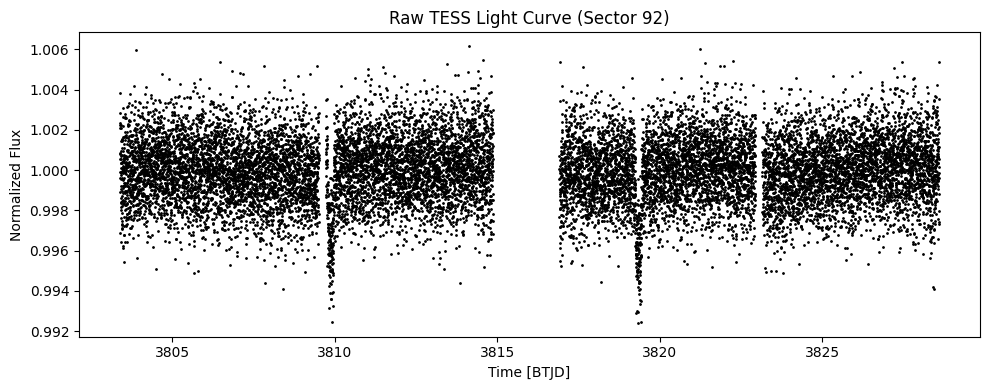

t0_guess = 3819.342096677204


sample: 100%|██████████| 2000/2000 [1:01:09<00:00,  1.83s/it, 1023 steps of size 1.05e-04. acc. prob=0.84]


===== Global transit fit (Sector 92) =====
t0       = 1.738497 ± 0.037158
Period   = 4.265488 ± 0.000041 days
Duration = 0.169169 ± 0.000107 days
r (Rp/R*)= 0.0455 ± 0.0010
b        = 0.1508 ± 0.0002
u1       = 0.8282 ± 0.0004
u2       = 0.8304 ± 0.0001
sigma_jit= 0.000351 ± 0.000048
model_flux_map min, max: 0.996480237286211 1.000428837523113


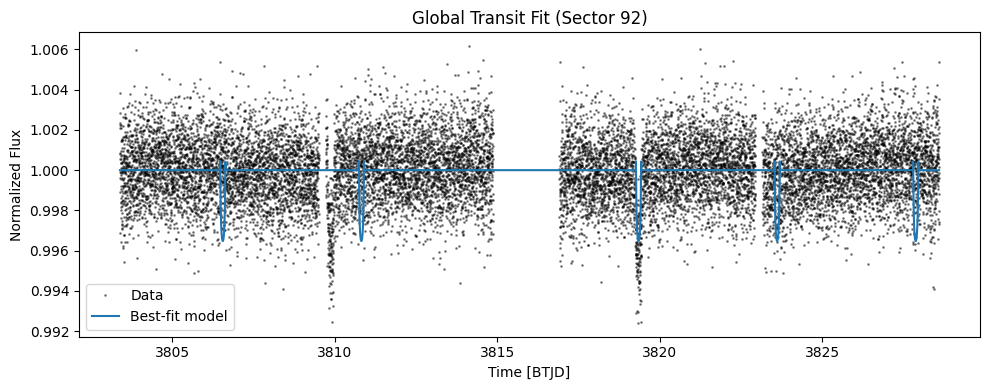

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")

# 读取 Sector 92 光变
lc = sector_data[(92, 120)]

time_np = lc.time.value
flux_np = lc.flux.value

# 去掉 NaN
mask = np.isfinite(time_np) & np.isfinite(flux_np)
time_np = time_np[mask]
flux_np = flux_np[mask]

plt.figure(figsize=(10, 4))
plt.plot(time_np, flux_np, ".k", ms=2)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Raw TESS Light Curve (Sector 92)")
plt.tight_layout()
plt.show()

# 简单误差估计
sigma0 = float(np.std(flux_np))
err_np = np.ones_like(flux_np) * sigma0

# 用最深点当 t0 初始猜测
t0_guess = float(time_np[np.argmin(flux_np)])
print("t0_guess =", t0_guess)

def transit_model_global(t, yerr, t0_guess, y=None):
    """
    Global transit model: 用整个 sector 的光变来拟合
    period, t0, duration, r, b, limb darkening, jitter.
    """

    # t0
    t0 = numpyro.sample("t0", dist.Normal(t0_guess, 1.0))

    # period: log-uniform [1, 20] 天
    logP = numpyro.sample("logP", dist.Uniform(jnp.log(1.0), jnp.log(20.0)))
    P = numpyro.deterministic("period", jnp.exp(logP))

    # duration: log-uniform [0.05, 0.3] 天
    logD = numpyro.sample("logD", dist.Uniform(jnp.log(0.05), jnp.log(0.3)))
    D = numpyro.deterministic("duration", jnp.exp(logD))

    # 行星和几何参数
    r = numpyro.sample("r", dist.Uniform(0.0001, 0.3))
    b = numpyro.sample("b", dist.Uniform(0.0, 1.0))

    # limb darkening
    u1 = numpyro.sample("u1", dist.Uniform(0.0, 1.0))
    u2 = numpyro.sample("u2", dist.Uniform(0.0, 1.0))
    u = jnp.array([u1, u2])

    # jitter
    sigma_jit = numpyro.sample("sigma_jit", dist.HalfNormal(0.0002))

    # 轨道
    orbit = TransitOrbit(
        period=P,
        duration=D,
        time_transit=t0,
        impact_param=b,
        radius_ratio=r,
    )

    # ★ 关键修改：先算 ΔF，再做 1 + ΔF 变成归一化通量
    delta_flux = limb_dark_light_curve(orbit, u)(t)   # ΔF, out-of-transit≈0, transit<0
    model_flux = 1.0 + delta_flux                     # baseline≈1，有凌星时往下掉

    # 似然
    sigma_tot = jnp.sqrt(yerr**2 + sigma_jit**2)
    numpyro.sample("obs", dist.Normal(model_flux, sigma_tot), obs=y)



# 运行 MCMC
t = jnp.array(time_np)
f = jnp.array(flux_np)
e = jnp.array(err_np)

kernel = NUTS(transit_model_global)
mcmc = MCMC(kernel, num_warmup=1500, num_samples=500, num_chains=1)

rng_key = jax.random.PRNGKey(42)
mcmc.run(rng_key, t, e, t0_guess, y=f)
samples = mcmc.get_samples()


def summarize_param(name):
    arr = np.array(samples[name])
    return arr.mean(), arr.std()


t0_mean, t0_std = summarize_param("t0")
P_mean, P_std = summarize_param("period")
D_mean, D_std = summarize_param("duration")
r_mean, r_std = summarize_param("r")
b_mean, b_std = summarize_param("b")
u1_mean, u1_std = summarize_param("u1")
u2_mean, u2_std = summarize_param("u2")
sj_mean, sj_std = summarize_param("sigma_jit")

print("===== Global transit fit (Sector 92) =====")
print(f"t0       = {t0_mean:.6f} ± {t0_std:.6f}")
print(f"Period   = {P_mean:.6f} ± {P_std:.6f} days")
print(f"Duration = {D_mean:.6f} ± {D_std:.6f} days")
print(f"r (Rp/R*)= {r_mean:.4f} ± {r_std:.4f}")
print(f"b        = {b_mean:.4f} ± {b_std:.4f}")
print(f"u1       = {u1_mean:.4f} ± {u1_std:.4f}")
print(f"u2       = {u2_mean:.4f} ± {u2_std:.4f}")
print(f"sigma_jit= {sj_mean:.6f} ± {sj_std:.6f}")

# 用后验中位数画 best-fit model
theta_med = {k: np.median(np.array(v)) for k, v in samples.items()}

orbit_map = TransitOrbit(
    period=theta_med["period"],
    duration=theta_med["duration"],
    time_transit=theta_med["t0"],
    impact_param=theta_med["b"],
    radius_ratio=theta_med["r"],
)
u_map = jnp.array([theta_med["u1"], theta_med["u2"]])

delta_flux_map = limb_dark_light_curve(orbit_map, u_map)(t)
model_flux_map = 1.0 + np.array(delta_flux_map)


print("model_flux_map min, max:", model_flux_map.min(), model_flux_map.max())

plt.figure(figsize=(10, 4))
plt.plot(time_np, flux_np, ".k", ms=2, alpha=0.4, label="Data")
plt.plot(time_np, model_flux_map, "-", lw=1.5, label="Best-fit model")
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Global Transit Fit (Sector 92)")
plt.legend()
plt.tight_layout()
plt.show()


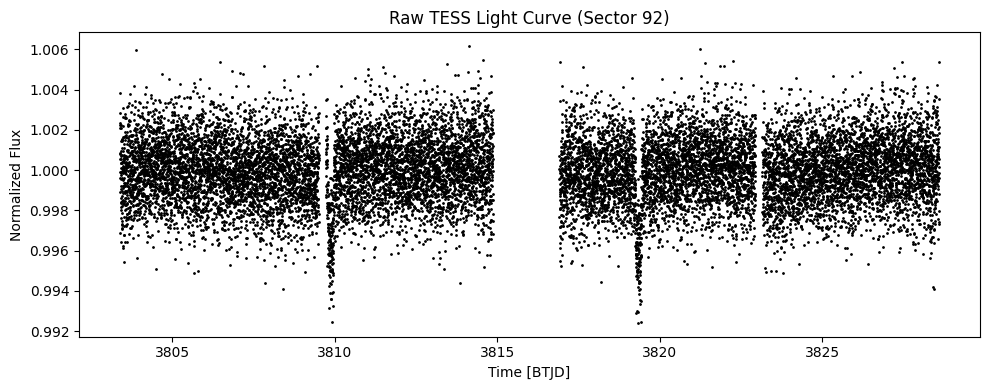

t0_guess = 3819.342096677204


sample: 100%|██████████| 2000/2000 [1:01:09<00:00,  1.83s/it, 1023 steps of size 1.05e-04. acc. prob=0.84]


===== Global transit fit (Sector 92) =====
t0       = 1.738497 ± 0.037158
Period   = 4.265488 ± 0.000041 days
Duration = 0.169169 ± 0.000107 days
r (Rp/R*)= 0.0455 ± 0.0010
b        = 0.1508 ± 0.0002
u1       = 0.8282 ± 0.0004
u2       = 0.8304 ± 0.0001
sigma_jit= 0.000351 ± 0.000048
model_flux_map min, max: 0.996480237286211 1.000428837523113


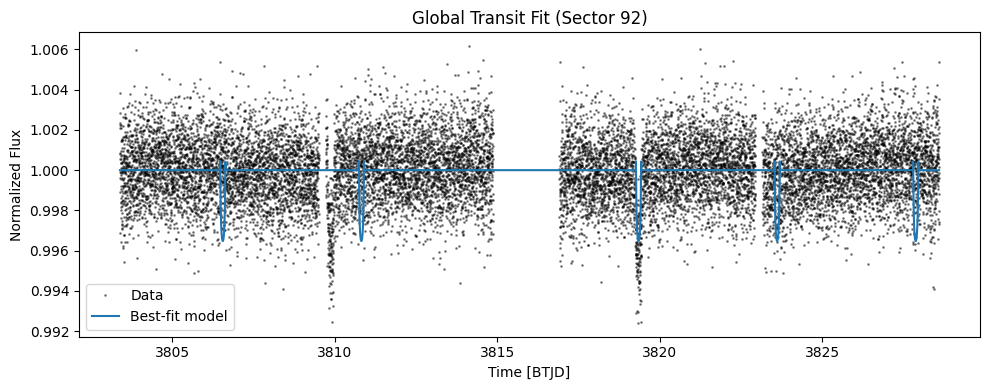

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")

# 读取 Sector 92 光变
lc = sector_data[(92, 120)]

time_np = lc.time.value
flux_np = lc.flux.value

# 去掉 NaN
mask = np.isfinite(time_np) & np.isfinite(flux_np)
time_np = time_np[mask]
flux_np = flux_np[mask]

plt.figure(figsize=(10, 4))
plt.plot(time_np, flux_np, ".k", ms=2)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Raw TESS Light Curve (Sector 92)")
plt.tight_layout()
plt.show()

# 简单误差估计
sigma0 = float(np.std(flux_np))
err_np = np.ones_like(flux_np) * sigma0

# 用最深点当 t0 初始猜测
t0_guess = float(time_np[np.argmin(flux_np)])
print("t0_guess =", t0_guess)

def transit_model_global(t, yerr, t0_guess, y=None):
    """
    Global transit model: 用整个 sector 的光变来拟合
    period, t0, duration, r, b, limb darkening, jitter.
    """

    # t0
    t0 = numpyro.sample("t0", dist.Normal(t0_guess, 1.0))

    # period: log-uniform [1, 20] 天
    logP = numpyro.sample("logP", dist.Uniform(jnp.log(1.0), jnp.log(20.0)))
    P = numpyro.deterministic("period", jnp.exp(logP))

    # duration: log-uniform [0.05, 0.3] 天
    logD = numpyro.sample("logD", dist.Uniform(jnp.log(0.05), jnp.log(0.3)))
    D = numpyro.deterministic("duration", jnp.exp(logD))

    # 行星和几何参数
    r = numpyro.sample("r", dist.Uniform(0.0001, 0.3))
    b = numpyro.sample("b", dist.Uniform(0.0, 1.0))

    # limb darkening
    u1 = numpyro.sample("u1", dist.Uniform(0.0, 1.0))
    u2 = numpyro.sample("u2", dist.Uniform(0.0, 1.0))
    u = jnp.array([u1, u2])

    # jitter
    sigma_jit = numpyro.sample("sigma_jit", dist.HalfNormal(0.0002))

    # 轨道
    orbit = TransitOrbit(
        period=P,
        duration=D,
        time_transit=t0,
        impact_param=b,
        radius_ratio=r,
    )

    # ★ 关键修改：先算 ΔF，再做 1 + ΔF 变成归一化通量
    delta_flux = limb_dark_light_curve(orbit, u)(t)   # ΔF, out-of-transit≈0, transit<0
    model_flux = 1.0 + delta_flux                     # baseline≈1，有凌星时往下掉

    # 似然
    sigma_tot = jnp.sqrt(yerr**2 + sigma_jit**2)
    numpyro.sample("obs", dist.Normal(model_flux, sigma_tot), obs=y)



# 运行 MCMC
t = jnp.array(time_np)
f = jnp.array(flux_np)
e = jnp.array(err_np)

kernel = NUTS(transit_model_global)
mcmc = MCMC(kernel, num_warmup=1500, num_samples=500, num_chains=1)

rng_key = jax.random.PRNGKey(42)
mcmc.run(rng_key, t, e, t0_guess, y=f)
samples = mcmc.get_samples()


def summarize_param(name):
    arr = np.array(samples[name])
    return arr.mean(), arr.std()


t0_mean, t0_std = summarize_param("t0")
P_mean, P_std = summarize_param("period")
D_mean, D_std = summarize_param("duration")
r_mean, r_std = summarize_param("r")
b_mean, b_std = summarize_param("b")
u1_mean, u1_std = summarize_param("u1")
u2_mean, u2_std = summarize_param("u2")
sj_mean, sj_std = summarize_param("sigma_jit")

print("===== Global transit fit (Sector 92) =====")
print(f"t0       = {t0_mean:.6f} ± {t0_std:.6f}")
print(f"Period   = {P_mean:.6f} ± {P_std:.6f} days")
print(f"Duration = {D_mean:.6f} ± {D_std:.6f} days")
print(f"r (Rp/R*)= {r_mean:.4f} ± {r_std:.4f}")
print(f"b        = {b_mean:.4f} ± {b_std:.4f}")
print(f"u1       = {u1_mean:.4f} ± {u1_std:.4f}")
print(f"u2       = {u2_mean:.4f} ± {u2_std:.4f}")
print(f"sigma_jit= {sj_mean:.6f} ± {sj_std:.6f}")

# 用后验中位数画 best-fit model
theta_med = {k: np.median(np.array(v)) for k, v in samples.items()}

orbit_map = TransitOrbit(
    period=theta_med["period"],
    duration=theta_med["duration"],
    time_transit=theta_med["t0"],
    impact_param=theta_med["b"],
    radius_ratio=theta_med["r"],
)
u_map = jnp.array([theta_med["u1"], theta_med["u2"]])

delta_flux_map = limb_dark_light_curve(orbit_map, u_map)(t)
model_flux_map = 1.0 + np.array(delta_flux_map)


print("model_flux_map min, max:", model_flux_map.min(), model_flux_map.max())

plt.figure(figsize=(10, 4))
plt.plot(time_np, flux_np, ".k", ms=2, alpha=0.4, label="Data")
plt.plot(time_np, model_flux_map, "-", lw=1.5, label="Best-fit model")
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Global Transit Fit (Sector 92)")
plt.legend()
plt.tight_layout()
plt.show()


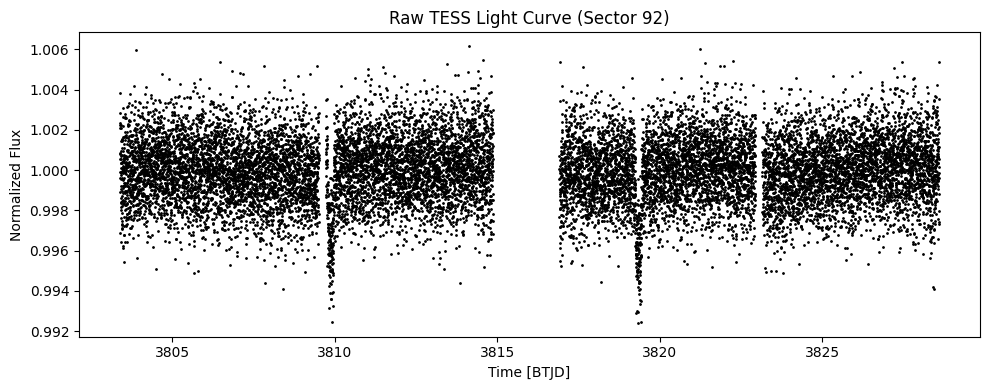

t0_guess = 3819.342096677204


sample: 100%|██████████| 2000/2000 [1:01:09<00:00,  1.83s/it, 1023 steps of size 1.05e-04. acc. prob=0.84]


===== Global transit fit (Sector 92) =====
t0       = 1.738497 ± 0.037158
Period   = 4.265488 ± 0.000041 days
Duration = 0.169169 ± 0.000107 days
r (Rp/R*)= 0.0455 ± 0.0010
b        = 0.1508 ± 0.0002
u1       = 0.8282 ± 0.0004
u2       = 0.8304 ± 0.0001
sigma_jit= 0.000351 ± 0.000048
model_flux_map min, max: 0.996480237286211 1.000428837523113


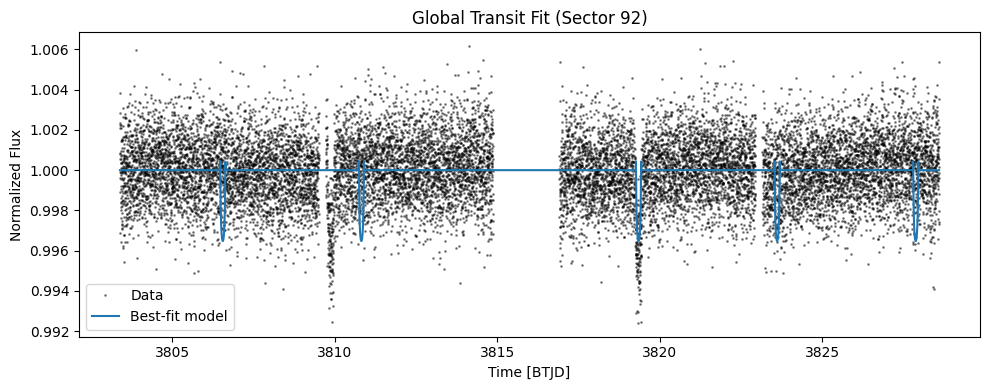

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")

# 读取 Sector 92 光变
lc = sector_data[(92, 120)]

time_np = lc.time.value
flux_np = lc.flux.value

# 去掉 NaN
mask = np.isfinite(time_np) & np.isfinite(flux_np)
time_np = time_np[mask]
flux_np = flux_np[mask]

plt.figure(figsize=(10, 4))
plt.plot(time_np, flux_np, ".k", ms=2)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Raw TESS Light Curve (Sector 92)")
plt.tight_layout()
plt.show()

# 简单误差估计
sigma0 = float(np.std(flux_np))
err_np = np.ones_like(flux_np) * sigma0

# 用最深点当 t0 初始猜测
t0_guess = float(time_np[np.argmin(flux_np)])
print("t0_guess =", t0_guess)

def transit_model_global(t, yerr, t0_guess, y=None):
    """
    Global transit model: 用整个 sector 的光变来拟合
    period, t0, duration, r, b, limb darkening, jitter.
    """

    # t0
    t0 = numpyro.sample("t0", dist.Normal(t0_guess, 1.0))

    # period: log-uniform [1, 20] 天
    logP = numpyro.sample("logP", dist.Uniform(jnp.log(1.0), jnp.log(20.0)))
    P = numpyro.deterministic("period", jnp.exp(logP))

    # duration: log-uniform [0.05, 0.3] 天
    logD = numpyro.sample("logD", dist.Uniform(jnp.log(0.05), jnp.log(0.3)))
    D = numpyro.deterministic("duration", jnp.exp(logD))

    # 行星和几何参数
    r = numpyro.sample("r", dist.Uniform(0.0001, 0.3))
    b = numpyro.sample("b", dist.Uniform(0.0, 1.0))

    # limb darkening
    u1 = numpyro.sample("u1", dist.Uniform(0.0, 1.0))
    u2 = numpyro.sample("u2", dist.Uniform(0.0, 1.0))
    u = jnp.array([u1, u2])

    # jitter
    sigma_jit = numpyro.sample("sigma_jit", dist.HalfNormal(0.0002))

    # 轨道
    orbit = TransitOrbit(
        period=P,
        duration=D,
        time_transit=t0,
        impact_param=b,
        radius_ratio=r,
    )

    # ★ 关键修改：先算 ΔF，再做 1 + ΔF 变成归一化通量
    delta_flux = limb_dark_light_curve(orbit, u)(t)   # ΔF, out-of-transit≈0, transit<0
    model_flux = 1.0 + delta_flux                     # baseline≈1，有凌星时往下掉

    # 似然
    sigma_tot = jnp.sqrt(yerr**2 + sigma_jit**2)
    numpyro.sample("obs", dist.Normal(model_flux, sigma_tot), obs=y)



# 运行 MCMC
t = jnp.array(time_np)
f = jnp.array(flux_np)
e = jnp.array(err_np)

kernel = NUTS(transit_model_global)
mcmc = MCMC(kernel, num_warmup=1500, num_samples=500, num_chains=1)

rng_key = jax.random.PRNGKey(42)
mcmc.run(rng_key, t, e, t0_guess, y=f)
samples = mcmc.get_samples()


def summarize_param(name):
    arr = np.array(samples[name])
    return arr.mean(), arr.std()


t0_mean, t0_std = summarize_param("t0")
P_mean, P_std = summarize_param("period")
D_mean, D_std = summarize_param("duration")
r_mean, r_std = summarize_param("r")
b_mean, b_std = summarize_param("b")
u1_mean, u1_std = summarize_param("u1")
u2_mean, u2_std = summarize_param("u2")
sj_mean, sj_std = summarize_param("sigma_jit")

print("===== Global transit fit (Sector 92) =====")
print(f"t0       = {t0_mean:.6f} ± {t0_std:.6f}")
print(f"Period   = {P_mean:.6f} ± {P_std:.6f} days")
print(f"Duration = {D_mean:.6f} ± {D_std:.6f} days")
print(f"r (Rp/R*)= {r_mean:.4f} ± {r_std:.4f}")
print(f"b        = {b_mean:.4f} ± {b_std:.4f}")
print(f"u1       = {u1_mean:.4f} ± {u1_std:.4f}")
print(f"u2       = {u2_mean:.4f} ± {u2_std:.4f}")
print(f"sigma_jit= {sj_mean:.6f} ± {sj_std:.6f}")

# 用后验中位数画 best-fit model
theta_med = {k: np.median(np.array(v)) for k, v in samples.items()}

orbit_map = TransitOrbit(
    period=theta_med["period"],
    duration=theta_med["duration"],
    time_transit=theta_med["t0"],
    impact_param=theta_med["b"],
    radius_ratio=theta_med["r"],
)
u_map = jnp.array([theta_med["u1"], theta_med["u2"]])

delta_flux_map = limb_dark_light_curve(orbit_map, u_map)(t)
model_flux_map = 1.0 + np.array(delta_flux_map)


print("model_flux_map min, max:", model_flux_map.min(), model_flux_map.max())

plt.figure(figsize=(10, 4))
plt.plot(time_np, flux_np, ".k", ms=2, alpha=0.4, label="Data")
plt.plot(time_np, model_flux_map, "-", lw=1.5, label="Best-fit model")
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Global Transit Fit (Sector 92)")
plt.legend()
plt.tight_layout()
plt.show()


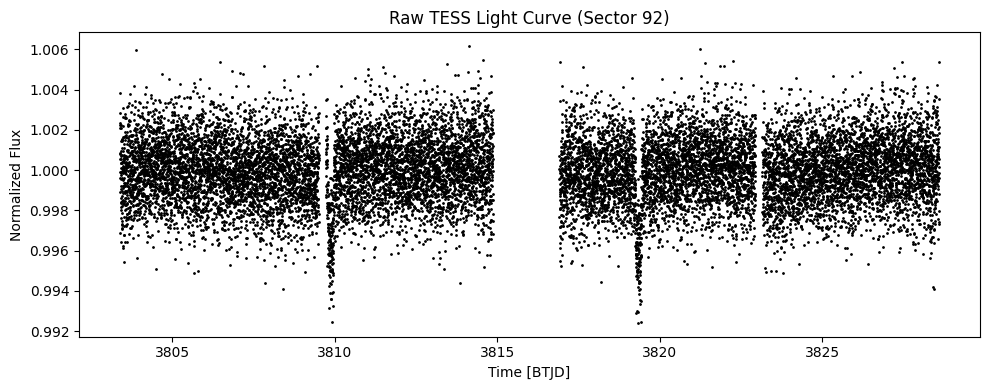

t0_guess = 3819.342096677204


sample: 100%|██████████| 2000/2000 [1:01:09<00:00,  1.83s/it, 1023 steps of size 1.05e-04. acc. prob=0.84]


===== Global transit fit (Sector 92) =====
t0       = 1.738497 ± 0.037158
Period   = 4.265488 ± 0.000041 days
Duration = 0.169169 ± 0.000107 days
r (Rp/R*)= 0.0455 ± 0.0010
b        = 0.1508 ± 0.0002
u1       = 0.8282 ± 0.0004
u2       = 0.8304 ± 0.0001
sigma_jit= 0.000351 ± 0.000048
model_flux_map min, max: 0.996480237286211 1.000428837523113


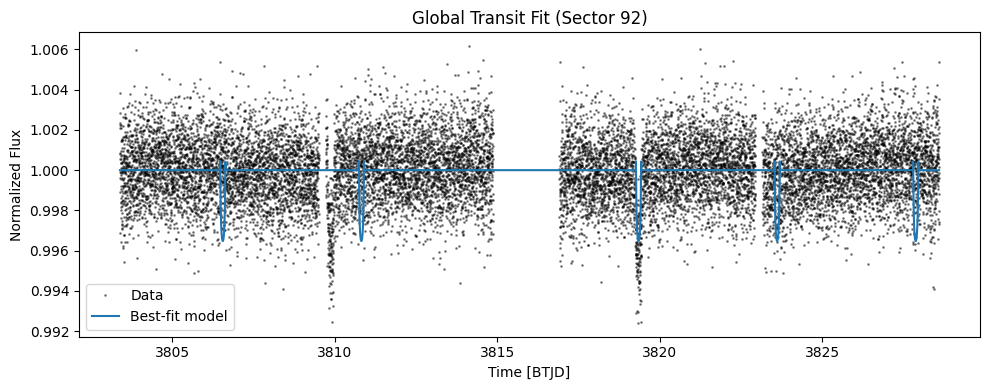

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")

# 读取 Sector 92 光变
lc = sector_data[(92, 120)]

time_np = lc.time.value
flux_np = lc.flux.value

# 去掉 NaN
mask = np.isfinite(time_np) & np.isfinite(flux_np)
time_np = time_np[mask]
flux_np = flux_np[mask]

plt.figure(figsize=(10, 4))
plt.plot(time_np, flux_np, ".k", ms=2)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Raw TESS Light Curve (Sector 92)")
plt.tight_layout()
plt.show()

# 简单误差估计
sigma0 = float(np.std(flux_np))
err_np = np.ones_like(flux_np) * sigma0

# 用最深点当 t0 初始猜测
t0_guess = float(time_np[np.argmin(flux_np)])
print("t0_guess =", t0_guess)

def transit_model_global(t, yerr, t0_guess, y=None):
    """
    Global transit model: 用整个 sector 的光变来拟合
    period, t0, duration, r, b, limb darkening, jitter.
    """

    # t0
    t0 = numpyro.sample("t0", dist.Normal(t0_guess, 1.0))

    # period: log-uniform [1, 20] 天
    logP = numpyro.sample("logP", dist.Uniform(jnp.log(1.0), jnp.log(20.0)))
    P = numpyro.deterministic("period", jnp.exp(logP))

    # duration: log-uniform [0.05, 0.3] 天
    logD = numpyro.sample("logD", dist.Uniform(jnp.log(0.05), jnp.log(0.3)))
    D = numpyro.deterministic("duration", jnp.exp(logD))

    # 行星和几何参数
    r = numpyro.sample("r", dist.Uniform(0.0001, 0.3))
    b = numpyro.sample("b", dist.Uniform(0.0, 1.0))

    # limb darkening
    u1 = numpyro.sample("u1", dist.Uniform(0.0, 1.0))
    u2 = numpyro.sample("u2", dist.Uniform(0.0, 1.0))
    u = jnp.array([u1, u2])

    # jitter
    sigma_jit = numpyro.sample("sigma_jit", dist.HalfNormal(0.0002))

    # 轨道
    orbit = TransitOrbit(
        period=P,
        duration=D,
        time_transit=t0,
        impact_param=b,
        radius_ratio=r,
    )

    # ★ 关键修改：先算 ΔF，再做 1 + ΔF 变成归一化通量
    delta_flux = limb_dark_light_curve(orbit, u)(t)   # ΔF, out-of-transit≈0, transit<0
    model_flux = 1.0 + delta_flux                     # baseline≈1，有凌星时往下掉

    # 似然
    sigma_tot = jnp.sqrt(yerr**2 + sigma_jit**2)
    numpyro.sample("obs", dist.Normal(model_flux, sigma_tot), obs=y)



# 运行 MCMC
t = jnp.array(time_np)
f = jnp.array(flux_np)
e = jnp.array(err_np)

kernel = NUTS(transit_model_global)
mcmc = MCMC(kernel, num_warmup=1500, num_samples=500, num_chains=1)

rng_key = jax.random.PRNGKey(42)
mcmc.run(rng_key, t, e, t0_guess, y=f)
samples = mcmc.get_samples()


def summarize_param(name):
    arr = np.array(samples[name])
    return arr.mean(), arr.std()


t0_mean, t0_std = summarize_param("t0")
P_mean, P_std = summarize_param("period")
D_mean, D_std = summarize_param("duration")
r_mean, r_std = summarize_param("r")
b_mean, b_std = summarize_param("b")
u1_mean, u1_std = summarize_param("u1")
u2_mean, u2_std = summarize_param("u2")
sj_mean, sj_std = summarize_param("sigma_jit")

print("===== Global transit fit (Sector 92) =====")
print(f"t0       = {t0_mean:.6f} ± {t0_std:.6f}")
print(f"Period   = {P_mean:.6f} ± {P_std:.6f} days")
print(f"Duration = {D_mean:.6f} ± {D_std:.6f} days")
print(f"r (Rp/R*)= {r_mean:.4f} ± {r_std:.4f}")
print(f"b        = {b_mean:.4f} ± {b_std:.4f}")
print(f"u1       = {u1_mean:.4f} ± {u1_std:.4f}")
print(f"u2       = {u2_mean:.4f} ± {u2_std:.4f}")
print(f"sigma_jit= {sj_mean:.6f} ± {sj_std:.6f}")

# 用后验中位数画 best-fit model
theta_med = {k: np.median(np.array(v)) for k, v in samples.items()}

orbit_map = TransitOrbit(
    period=theta_med["period"],
    duration=theta_med["duration"],
    time_transit=theta_med["t0"],
    impact_param=theta_med["b"],
    radius_ratio=theta_med["r"],
)
u_map = jnp.array([theta_med["u1"], theta_med["u2"]])

delta_flux_map = limb_dark_light_curve(orbit_map, u_map)(t)
model_flux_map = 1.0 + np.array(delta_flux_map)


print("model_flux_map min, max:", model_flux_map.min(), model_flux_map.max())

plt.figure(figsize=(10, 4))
plt.plot(time_np, flux_np, ".k", ms=2, alpha=0.4, label="Data")
plt.plot(time_np, model_flux_map, "-", lw=1.5, label="Best-fit model")
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Global Transit Fit (Sector 92)")
plt.legend()
plt.tight_layout()
plt.show()


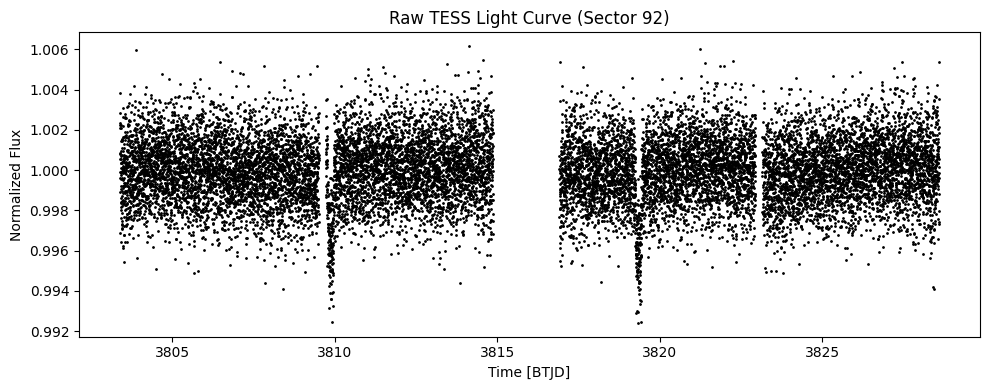

t0_guess = 3819.342096677204


sample: 100%|██████████| 2000/2000 [1:01:09<00:00,  1.83s/it, 1023 steps of size 1.05e-04. acc. prob=0.84]


===== Global transit fit (Sector 92) =====
t0       = 1.738497 ± 0.037158
Period   = 4.265488 ± 0.000041 days
Duration = 0.169169 ± 0.000107 days
r (Rp/R*)= 0.0455 ± 0.0010
b        = 0.1508 ± 0.0002
u1       = 0.8282 ± 0.0004
u2       = 0.8304 ± 0.0001
sigma_jit= 0.000351 ± 0.000048
model_flux_map min, max: 0.996480237286211 1.000428837523113


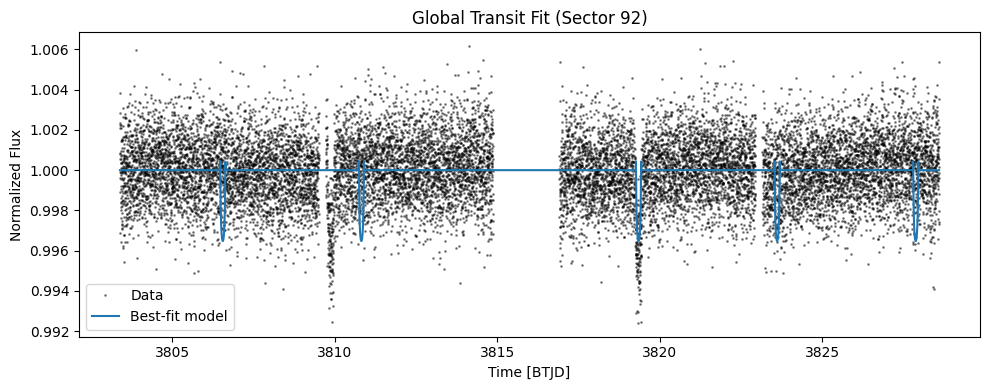

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")

# 读取 Sector 92 光变
lc = sector_data[(92, 120)]

time_np = lc.time.value
flux_np = lc.flux.value

# 去掉 NaN
mask = np.isfinite(time_np) & np.isfinite(flux_np)
time_np = time_np[mask]
flux_np = flux_np[mask]

plt.figure(figsize=(10, 4))
plt.plot(time_np, flux_np, ".k", ms=2)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Raw TESS Light Curve (Sector 92)")
plt.tight_layout()
plt.show()

# 简单误差估计
sigma0 = float(np.std(flux_np))
err_np = np.ones_like(flux_np) * sigma0

# 用最深点当 t0 初始猜测
t0_guess = float(time_np[np.argmin(flux_np)])
print("t0_guess =", t0_guess)

def transit_model_global(t, yerr, t0_guess, y=None):
    """
    Global transit model: 用整个 sector 的光变来拟合
    period, t0, duration, r, b, limb darkening, jitter.
    """

    # t0
    t0 = numpyro.sample("t0", dist.Normal(t0_guess, 1.0))

    # period: log-uniform [1, 20] 天
    logP = numpyro.sample("logP", dist.Uniform(jnp.log(1.0), jnp.log(20.0)))
    P = numpyro.deterministic("period", jnp.exp(logP))

    # duration: log-uniform [0.05, 0.3] 天
    logD = numpyro.sample("logD", dist.Uniform(jnp.log(0.05), jnp.log(0.3)))
    D = numpyro.deterministic("duration", jnp.exp(logD))

    # 行星和几何参数
    r = numpyro.sample("r", dist.Uniform(0.0001, 0.3))
    b = numpyro.sample("b", dist.Uniform(0.0, 1.0))

    # limb darkening
    u1 = numpyro.sample("u1", dist.Uniform(0.0, 1.0))
    u2 = numpyro.sample("u2", dist.Uniform(0.0, 1.0))
    u = jnp.array([u1, u2])

    # jitter
    sigma_jit = numpyro.sample("sigma_jit", dist.HalfNormal(0.0002))

    # 轨道
    orbit = TransitOrbit(
        period=P,
        duration=D,
        time_transit=t0,
        impact_param=b,
        radius_ratio=r,
    )

    # ★ 关键修改：先算 ΔF，再做 1 + ΔF 变成归一化通量
    delta_flux = limb_dark_light_curve(orbit, u)(t)   # ΔF, out-of-transit≈0, transit<0
    model_flux = 1.0 + delta_flux                     # baseline≈1，有凌星时往下掉

    # 似然
    sigma_tot = jnp.sqrt(yerr**2 + sigma_jit**2)
    numpyro.sample("obs", dist.Normal(model_flux, sigma_tot), obs=y)



# 运行 MCMC
t = jnp.array(time_np)
f = jnp.array(flux_np)
e = jnp.array(err_np)

kernel = NUTS(transit_model_global)
mcmc = MCMC(kernel, num_warmup=1500, num_samples=500, num_chains=1)

rng_key = jax.random.PRNGKey(42)
mcmc.run(rng_key, t, e, t0_guess, y=f)
samples = mcmc.get_samples()


def summarize_param(name):
    arr = np.array(samples[name])
    return arr.mean(), arr.std()


t0_mean, t0_std = summarize_param("t0")
P_mean, P_std = summarize_param("period")
D_mean, D_std = summarize_param("duration")
r_mean, r_std = summarize_param("r")
b_mean, b_std = summarize_param("b")
u1_mean, u1_std = summarize_param("u1")
u2_mean, u2_std = summarize_param("u2")
sj_mean, sj_std = summarize_param("sigma_jit")

print("===== Global transit fit (Sector 92) =====")
print(f"t0       = {t0_mean:.6f} ± {t0_std:.6f}")
print(f"Period   = {P_mean:.6f} ± {P_std:.6f} days")
print(f"Duration = {D_mean:.6f} ± {D_std:.6f} days")
print(f"r (Rp/R*)= {r_mean:.4f} ± {r_std:.4f}")
print(f"b        = {b_mean:.4f} ± {b_std:.4f}")
print(f"u1       = {u1_mean:.4f} ± {u1_std:.4f}")
print(f"u2       = {u2_mean:.4f} ± {u2_std:.4f}")
print(f"sigma_jit= {sj_mean:.6f} ± {sj_std:.6f}")

# 用后验中位数画 best-fit model
theta_med = {k: np.median(np.array(v)) for k, v in samples.items()}

orbit_map = TransitOrbit(
    period=theta_med["period"],
    duration=theta_med["duration"],
    time_transit=theta_med["t0"],
    impact_param=theta_med["b"],
    radius_ratio=theta_med["r"],
)
u_map = jnp.array([theta_med["u1"], theta_med["u2"]])

delta_flux_map = limb_dark_light_curve(orbit_map, u_map)(t)
model_flux_map = 1.0 + np.array(delta_flux_map)


print("model_flux_map min, max:", model_flux_map.min(), model_flux_map.max())

plt.figure(figsize=(10, 4))
plt.plot(time_np, flux_np, ".k", ms=2, alpha=0.4, label="Data")
plt.plot(time_np, model_flux_map, "-", lw=1.5, label="Best-fit model")
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Global Transit Fit (Sector 92)")
plt.legend()
plt.tight_layout()
plt.show()


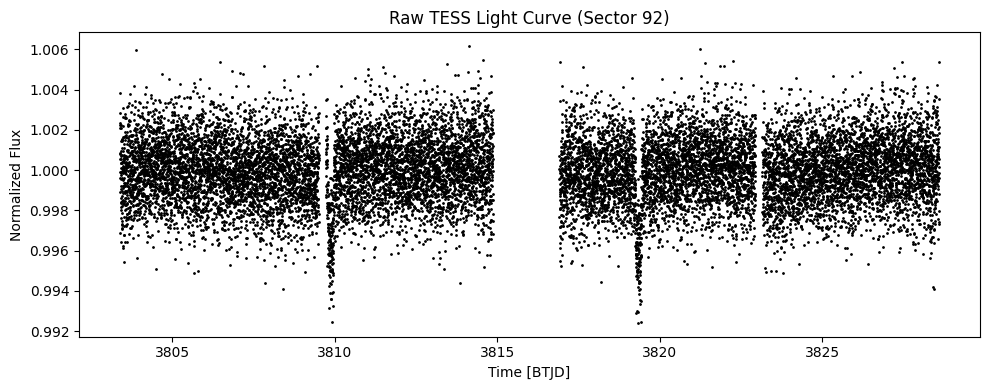

t0_guess = 3819.342096677204


sample: 100%|██████████| 2000/2000 [1:01:09<00:00,  1.83s/it, 1023 steps of size 1.05e-04. acc. prob=0.84]


===== Global transit fit (Sector 92) =====
t0       = 1.738497 ± 0.037158
Period   = 4.265488 ± 0.000041 days
Duration = 0.169169 ± 0.000107 days
r (Rp/R*)= 0.0455 ± 0.0010
b        = 0.1508 ± 0.0002
u1       = 0.8282 ± 0.0004
u2       = 0.8304 ± 0.0001
sigma_jit= 0.000351 ± 0.000048
model_flux_map min, max: 0.996480237286211 1.000428837523113


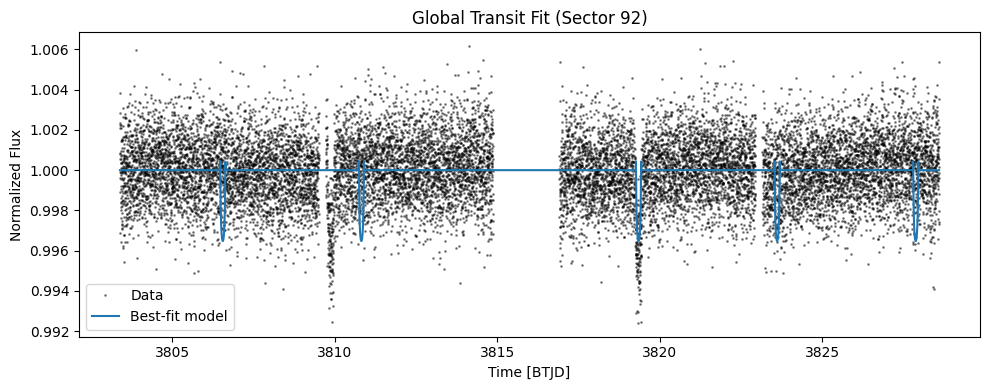

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")

# 读取 Sector 92 光变
lc = sector_data[(92, 120)]

time_np = lc.time.value
flux_np = lc.flux.value

# 去掉 NaN
mask = np.isfinite(time_np) & np.isfinite(flux_np)
time_np = time_np[mask]
flux_np = flux_np[mask]

plt.figure(figsize=(10, 4))
plt.plot(time_np, flux_np, ".k", ms=2)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Raw TESS Light Curve (Sector 92)")
plt.tight_layout()
plt.show()

# 简单误差估计
sigma0 = float(np.std(flux_np))
err_np = np.ones_like(flux_np) * sigma0

# 用最深点当 t0 初始猜测
t0_guess = float(time_np[np.argmin(flux_np)])
print("t0_guess =", t0_guess)

def transit_model_global(t, yerr, t0_guess, y=None):
    """
    Global transit model: 用整个 sector 的光变来拟合
    period, t0, duration, r, b, limb darkening, jitter.
    """

    # t0
    t0 = numpyro.sample("t0", dist.Normal(t0_guess, 1.0))

    # period: log-uniform [1, 20] 天
    logP = numpyro.sample("logP", dist.Uniform(jnp.log(1.0), jnp.log(20.0)))
    P = numpyro.deterministic("period", jnp.exp(logP))

    # duration: log-uniform [0.05, 0.3] 天
    logD = numpyro.sample("logD", dist.Uniform(jnp.log(0.05), jnp.log(0.3)))
    D = numpyro.deterministic("duration", jnp.exp(logD))

    # 行星和几何参数
    r = numpyro.sample("r", dist.Uniform(0.0001, 0.3))
    b = numpyro.sample("b", dist.Uniform(0.0, 1.0))

    # limb darkening
    u1 = numpyro.sample("u1", dist.Uniform(0.0, 1.0))
    u2 = numpyro.sample("u2", dist.Uniform(0.0, 1.0))
    u = jnp.array([u1, u2])

    # jitter
    sigma_jit = numpyro.sample("sigma_jit", dist.HalfNormal(0.0002))

    # 轨道
    orbit = TransitOrbit(
        period=P,
        duration=D,
        time_transit=t0,
        impact_param=b,
        radius_ratio=r,
    )

    # ★ 关键修改：先算 ΔF，再做 1 + ΔF 变成归一化通量
    delta_flux = limb_dark_light_curve(orbit, u)(t)   # ΔF, out-of-transit≈0, transit<0
    model_flux = 1.0 + delta_flux                     # baseline≈1，有凌星时往下掉

    # 似然
    sigma_tot = jnp.sqrt(yerr**2 + sigma_jit**2)
    numpyro.sample("obs", dist.Normal(model_flux, sigma_tot), obs=y)



# 运行 MCMC
t = jnp.array(time_np)
f = jnp.array(flux_np)
e = jnp.array(err_np)

kernel = NUTS(transit_model_global)
mcmc = MCMC(kernel, num_warmup=1500, num_samples=500, num_chains=1)

rng_key = jax.random.PRNGKey(42)
mcmc.run(rng_key, t, e, t0_guess, y=f)
samples = mcmc.get_samples()


def summarize_param(name):
    arr = np.array(samples[name])
    return arr.mean(), arr.std()


t0_mean, t0_std = summarize_param("t0")
P_mean, P_std = summarize_param("period")
D_mean, D_std = summarize_param("duration")
r_mean, r_std = summarize_param("r")
b_mean, b_std = summarize_param("b")
u1_mean, u1_std = summarize_param("u1")
u2_mean, u2_std = summarize_param("u2")
sj_mean, sj_std = summarize_param("sigma_jit")

print("===== Global transit fit (Sector 92) =====")
print(f"t0       = {t0_mean:.6f} ± {t0_std:.6f}")
print(f"Period   = {P_mean:.6f} ± {P_std:.6f} days")
print(f"Duration = {D_mean:.6f} ± {D_std:.6f} days")
print(f"r (Rp/R*)= {r_mean:.4f} ± {r_std:.4f}")
print(f"b        = {b_mean:.4f} ± {b_std:.4f}")
print(f"u1       = {u1_mean:.4f} ± {u1_std:.4f}")
print(f"u2       = {u2_mean:.4f} ± {u2_std:.4f}")
print(f"sigma_jit= {sj_mean:.6f} ± {sj_std:.6f}")

# 用后验中位数画 best-fit model
theta_med = {k: np.median(np.array(v)) for k, v in samples.items()}

orbit_map = TransitOrbit(
    period=theta_med["period"],
    duration=theta_med["duration"],
    time_transit=theta_med["t0"],
    impact_param=theta_med["b"],
    radius_ratio=theta_med["r"],
)
u_map = jnp.array([theta_med["u1"], theta_med["u2"]])

delta_flux_map = limb_dark_light_curve(orbit_map, u_map)(t)
model_flux_map = 1.0 + np.array(delta_flux_map)


print("model_flux_map min, max:", model_flux_map.min(), model_flux_map.max())

plt.figure(figsize=(10, 4))
plt.plot(time_np, flux_np, ".k", ms=2, alpha=0.4, label="Data")
plt.plot(time_np, model_flux_map, "-", lw=1.5, label="Best-fit model")
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Global Transit Fit (Sector 92)")
plt.legend()
plt.tight_layout()
plt.show()


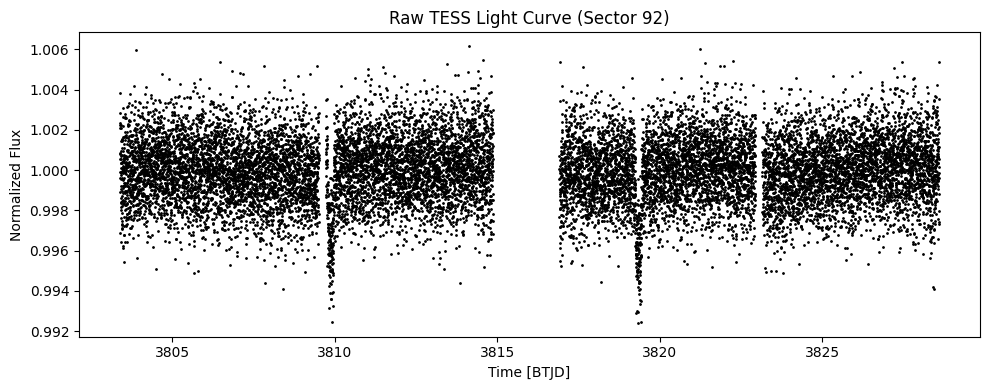

sigma = 0.0016291119391098619 prominence min = 0.0048873358173295856
Transit candidates: 3809.9148413333896 3819.342096677204


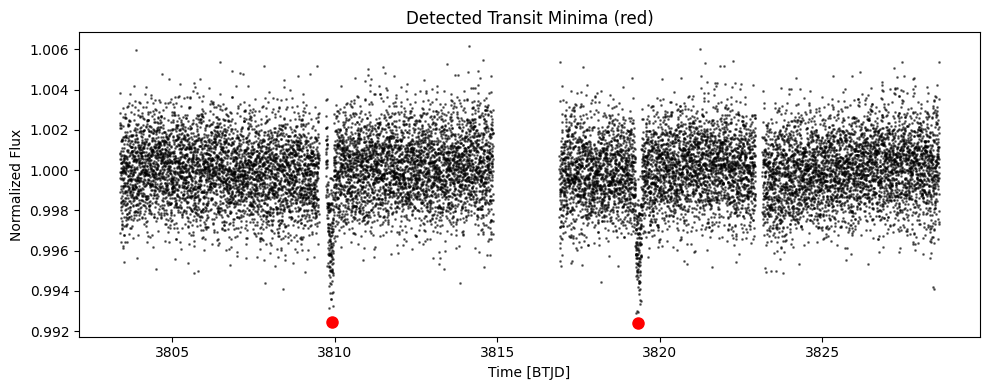

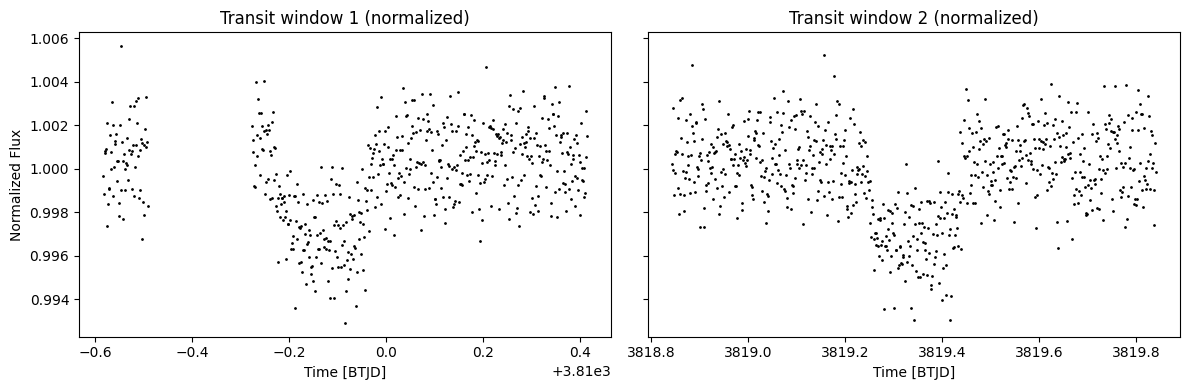

sample: 100%|██████████| 3000/3000 [00:06<00:00, 434.28it/s, 7 steps of size 6.35e-01. acc. prob=0.92]


===== Local transit fits =====
Transit 1 center time: 3809.876077 ± 0.004086
Transit 1 r (Rp/R*):   0.0545 ± 0.0019
Transit 1 depth ≈ r^2: 0.00298 ± 0.00020

Transit 2 center time: 3819.343196 ± 0.002254
Transit 2 r (Rp/R*):   0.0564 ± 0.0015
Transit 2 depth ≈ r^2: 0.00318 ± 0.00017

Difference (approx period): 9.467119 days
Transit 1 fit model_flux min/max: 0.9969351782565686 1.0


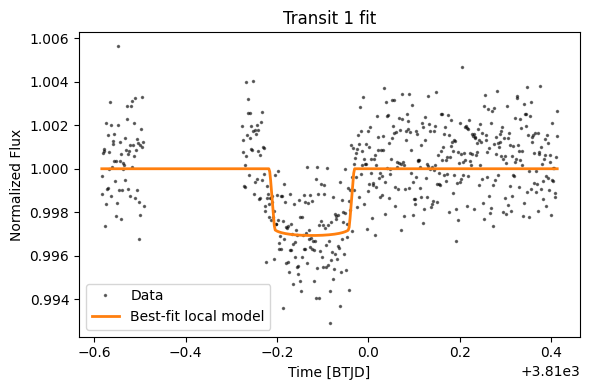

Transit 2 fit model_flux min/max: 0.9967264693168165 1.0


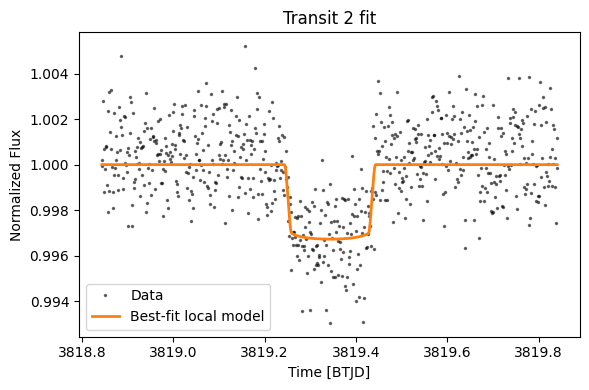

In [35]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

from scipy.signal import find_peaks

# ============================================
# 0. JAX / NumPyro 设置
# ============================================
jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")

# ============================================
# 1. 取出 Sector 92 光变 & 找两个 transit
# ============================================
lc = sector_data[(92,120)]

time_np = lc.time.value
flux_np = lc.flux.value

plt.figure(figsize=(10,4))
plt.plot(time_np, flux_np, ".k", ms=2)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Raw TESS Light Curve (Sector 92)")
plt.tight_layout()
plt.show()

inv_flux = 1.0 - flux_np
sigma = float(np.std(flux_np))
prom_min = 3.0 * sigma

print("sigma =", sigma, "prominence min =", prom_min)

peaks, props = find_peaks(
    inv_flux,
    distance=1000,
    prominence=prom_min
)

if len(peaks) < 2:
    prom_min = 3.0 * sigma
    print("放宽 prominence 到", prom_min)
    peaks, props = find_peaks(
        inv_flux,
        distance=1000,
        prominence=prom_min
    )
    print("新的候选数:", len(peaks))
    print("候选时间:", time_np[peaks])

prom = props["prominences"]
order = np.argsort(prom)[::-1]
main_peaks = peaks[order[:2]]
main_peaks = np.sort(main_peaks)

idx1, idx2 = main_peaks
t0_guess1 = time_np[idx1]
t0_guess2 = time_np[idx2]

print("Transit candidates:", t0_guess1, t0_guess2)

plt.figure(figsize=(10,4))
plt.plot(time_np, flux_np, ".k", ms=2, alpha=0.5)
plt.plot(time_np[main_peaks], flux_np[main_peaks], "or", ms=8)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Detected Transit Minima (red)")
plt.tight_layout()
plt.show()

# ============================================
# 2. 裁剪两个 transit 窗口，并在窗口内做局部归一化
# ============================================
def cut_transit(time_array, flux_array, t_center, window=0.15):
    mask = np.abs(time_array - t_center) < window
    t_cut = time_array[mask]
    f_raw = flux_array[mask]

    # 局部 baseline：用 median 去掉慢变化趋势
    baseline = np.median(f_raw)
    f_cut = f_raw / baseline

    sigma_loc = float(np.std(f_cut))
    e_cut = np.ones_like(f_cut) * sigma_loc
    return t_cut, f_cut, e_cut

t1, f1, e1 = cut_transit(time_np, flux_np, t0_guess1, window=0.5)
t2, f2, e2 = cut_transit(time_np, flux_np, t0_guess2, window=0.5)

fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)
axes[0].plot(t1, f1, ".k", ms=2)
axes[0].set_title("Transit window 1 (normalized)")
axes[1].plot(t2, f2, ".k", ms=2)
axes[1].set_title("Transit window 2 (normalized)")
for ax in axes:
    ax.set_xlabel("Time [BTJD]")
axes[0].set_ylabel("Normalized Flux")
plt.tight_layout()
plt.show()

# ============================================
# 3. 局部 transit 模型：拟合 t0、duration 和 r
# ============================================
def transit_model_local(t, yerr, t0_guess, y=None):
    # t0：以 t0_guess 为中心，给比较窄的先验（避免跑出窗口）
    t0 = numpyro.sample("t0", dist.Normal(t0_guess, 0.01))

    # duration：log-uniform [0.05, 0.3] 天
    logD = numpyro.sample("logD", dist.Uniform(jnp.log(0.05), jnp.log(0.3)))
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    # 半径比 r：让 MCMC 自己拟合，这样可以输出 depth
    r = numpyro.sample("r", dist.Uniform(0.01, 0.2))

    # impact parameter 固定一个合理值，避免太多简并
    b = 0.5

    # limb darkening 固定（局部窗口里影响不大）
    u = jnp.array([0.1, 0.06])

    orbit = TransitOrbit(
        period=10.0,        # dummy：局部窗口里只有一个 transit
        duration=duration,
        time_transit=t0,
        impact_param=b,
        radius_ratio=r,
    )

    # jaxoplanet 输出 ΔF（凌星外≈0，凌星内<0）
    delta_flux = limb_dark_light_curve(orbit, u)(t)
    model = 1.0 + delta_flux   # 我们的局部数据已经归一化到 ~1

    numpyro.deterministic("model_flux", model)
    numpyro.sample("obs", dist.Normal(model, yerr), obs=y)

# ============================================
# 4. 拟合每个窗口
# ============================================
def fit_window(time_array, flux_array, err_array, t0_guess, seed=0):
    t = jnp.array(time_array)
    f = jnp.array(flux_array)
    e = jnp.array(err_array)

    kernel = NUTS(transit_model_local)
    mcmc = MCMC(kernel, num_warmup=2000, num_samples=1000, num_chains=1)
    rng_key = jax.random.PRNGKey(seed)
    mcmc.run(rng_key, t, e, t0_guess, y=f)
    samples = mcmc.get_samples()

    t0_samples = np.array(samples["t0"])
    t0_mean = float(t0_samples.mean())
    t0_std  = float(t0_samples.std())

    r_samples = np.array(samples["r"])
    r_mean = float(r_samples.mean())
    r_std  = float(r_samples.std())

    # transit depth（近似）≈ r^2
    depth_samples = r_samples**2
    depth_mean = float(depth_samples.mean())
    depth_std  = float(depth_samples.std())

    return (t0_mean, t0_std,
            r_mean, r_std,
            depth_mean, depth_std,
            samples)

t0_1, t0_1_std, r1_mean, r1_std, d1_mean, d1_std, samples1 = fit_window(
    t1, f1, e1, t0_guess1, seed=1
)
t0_2, t0_2_std, r2_mean, r2_std, d2_mean, d2_std, samples2 = fit_window(
    t2, f2, e2, t0_guess2, seed=2
)

print("===== Local transit fits =====")
print(f"Transit 1 center time: {t0_1:.6f} ± {t0_1_std:.6f}")
print(f"Transit 1 r (Rp/R*):   {r1_mean:.4f} ± {r1_std:.4f}")
print(f"Transit 1 depth ≈ r^2: {d1_mean:.5f} ± {d1_std:.5f}")
print()
print(f"Transit 2 center time: {t0_2:.6f} ± {t0_2_std:.6f}")
print(f"Transit 2 r (Rp/R*):   {r2_mean:.4f} ± {r2_std:.4f}")
print(f"Transit 2 depth ≈ r^2: {d2_mean:.5f} ± {d2_std:.5f}")
print()
print(f"Difference (approx period): {t0_2 - t0_1:.6f} days")

# ============================================
# 5. 画每个窗口的拟合结果
# ============================================
def plot_fit(time_array, flux_array, samples, title):
    t_plot = np.linspace(time_array.min(), time_array.max(), 500)
    t_plot_jax = jnp.array(t_plot)

    t0_post = float(np.mean(np.array(samples["t0"])))
    D_post  = float(np.mean(np.array(samples["duration"])))
    r_post  = float(np.mean(np.array(samples["r"])))

    b = 0.5
    u = jnp.array([0.1, 0.06])

    orbit = TransitOrbit(
        period=10.0,
        duration=D_post,
        time_transit=t0_post,
        impact_param=b,
        radius_ratio=r_post,
    )
    delta_flux_plot = limb_dark_light_curve(orbit, u)(t_plot_jax)
    model_flux = 1.0 + np.array(delta_flux_plot)

    print(title, "model_flux min/max:", model_flux.min(), model_flux.max())

    plt.figure(figsize=(6,4))
    plt.plot(time_array, flux_array, ".k", ms=3, alpha=0.5, label="Data")
    plt.plot(t_plot, model_flux, "-C1", lw=2, label="Best-fit local model")
    plt.xlabel("Time [BTJD]")
    plt.ylabel("Normalized Flux")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_fit(t1, f1, samples1, "Transit 1 fit")
plot_fit(t2, f2, samples2, "Transit 2 fit")


In [ ]:
#try fixed P
#model global


In [ ]:
#reliable model for ttv
#apply to all warm jupiter oberved by TESS
#to infer companion / occurance rate around warm jupiter